### Git versioning

In [1]:
import git  #Requires Gitpython installed, to install do "$ pip install Gitpython" in your terminal
import pkg_resources
openfisca_france_location = pkg_resources.get_distribution('openfisca-france').location
repo = git.Repo(openfisca_france_location)
repo.git.status()

sha = repo.head.object.hexsha

print "---This notebook have been runed with--- \n","Openfisca-france :", repo.head.object.hexsha, '\n' 
print "Commit short SHA:", repo.git.rev_parse(sha, short=4)
print "Branch: ", repo.git.rev_parse('--abbrev-ref', "HEAD") #equivalent to: $git rev-parse --abbrev-ref HEAD
print "Date (y/m/d):", repo.git.show("-s", '--format=%ci', 'HEAD^')[:-5],"\n"  # equivalent to: $git show -s --format=%ci HEAD^

print "Openfisca-core :", git.Repo(pkg_resources.get_distribution('openfisca-core').location).head.object.hexsha, ' Date:', git.Repo(pkg_resources.get_distribution('openfisca-core').location).git.show("-s", '--format=%ci', 'HEAD^')[:-5]
print "Openfisca-france-data :", git.Repo(pkg_resources.get_distribution('openfisca-france-data').location).head.object.hexsha, ' Date:', git.Repo(pkg_resources.get_distribution('openfisca-france-data').location).git.show("-s", '--format=%ci', 'HEAD^')[:-5]
print "OpenFisca-Aggregates :", git.Repo(pkg_resources.get_distribution('OpenFisca-Aggregates').location).head.object.hexsha, ' Date:', git.Repo(pkg_resources.get_distribution('OpenFisca-Aggregates').location).git.show("-s", '--format=%ci', 'HEAD^')[:-5]
print "OpenFisca-Survey-Manager :", git.Repo(pkg_resources.get_distribution('OpenFisca-Survey-Manager').location).head.object.hexsha, ' Date:', git.Repo(pkg_resources.get_distribution('OpenFisca-Aggregates').location).git.show("-s", '--format=%ci', 'HEAD^')[:-5]

---This notebook have been runed with--- 
Openfisca-france : f710f63abb52a3395a126bd96e0f3f4bfd83d1a6 

Commit short SHA: f710
Branch:  mensualisation_wip
Date (y/m/d): 2016-07-26 13:55:47  

Openfisca-core : 4076f591f4bcb571391b65a989e1603fdc4cb759  Date: 2016-02-24 16:11:57 
Openfisca-france-data : a6b02e6909ee9c27169cd5cf73c51df9b1640ef9  Date: 2016-05-31 15:54:47 
OpenFisca-Aggregates : fd210d8cfdf6ed68f173d9d5c3eab4a4302ed2b9  Date: 2016-04-04 11:35:03 
OpenFisca-Survey-Manager : 868512d24307aa75cfa7bbbf8420542960963966  Date: 2016-04-04 11:35:03 


### Imports

In [2]:
%matplotlib inline
from __future__ import division

import calendar

from openfisca_core import periods
from openfisca_plugin_aggregates.tests.reform.test_aggregates_mensualized import create_survey_scenario
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator


import numpy as np
from numpy import (datetime64, logical_and as and_, logical_not as not_, logical_or as or_, logical_xor as xor_,
maximum as max_, minimum as min_, round)


#Faire des filtres pour Mahdi survey_scenario.create_data_frame_by_entity_key_plural

pd.set_option('expand_frame_repr', False)  #utile quand on utilise pandas en mode console
pd.set_option("display.max_rows",201)
pd.set_option("display.max_columns",201)

/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: During startup - 
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 1: Setting LC_COLLATE failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 2: Setting LC_TIME failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 3: Setting LC_MESSAGES failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 4: Setting LC_MONETARY failed, using "C" 

  warnings.warn(x, RRuntimeWarning)


# Create Survey Scenario

In [3]:
period = periods.period(2009)

In [4]:
period.this_year.this_month

Period((u'month', Instant((2009, 1, 1)), 1))

In [5]:
survey_scenario = create_survey_scenario(2009)
survey_scenario.new_simulation()


simulation = survey_scenario.simulation
scenario = survey_scenario

weight_foyers = survey_scenario.simulation.calculate_add('weight_foyers', period = period).astype(float)
weight_menages = survey_scenario.simulation.calculate_add('wprm', period = period).astype(float)
weight_familles = survey_scenario.simulation.calculate_add('weight_familles', period = period).astype(float)
weight_individus = survey_scenario.simulation.calculate_add('weight_individus', period = period).astype(float)
print weight_foyers.shape, weight_menages.shape, weight_familles.shape, weight_individus.shape

(52189,) (42709,) (48195,) (80431,)


In [6]:
def sum_by_entity(var, entity_key, roles = None):
    var_holder = simulation.compute_add(var)
    entity = simulation.entity_by_key_singular[entity_key]
    
    entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
    
    if roles is None:
        roles = range(10)
    
    target_array = np.empty(entity.count)
    target_array.fill(0)            
    for role in roles:  #max cardinality of roles
        boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
        target_array[entity_index_array[boolean_filter]] += var_holder.array[boolean_filter]
    return target_array



def sum_array_by_entity(array, entity_key, roles = None):
    entity = simulation.entity_by_key_singular[entity_key]
    entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
    if roles is None:
        roles = range(10)
    
    target_array = np.empty(entity.count)
    target_array.fill(0)            
    for role in roles:  #max cardinality of roles
        boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
        target_array[entity_index_array[boolean_filter]] += array[boolean_filter]
    return target_array
    

def cast_from_entity_to_role( var , roles = None):
    var_holder = simulation.compute_add(var)
    entity = var_holder.entity
    entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
    if roles is None:
        roles = range(entity.roles_count)
    target_array = np.empty(simulation.persons.count)
    target_array.fill(0)
    for role in roles:
        boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
        target_array[boolean_filter] = simulation.compute_add(var).array[entity_index_array[boolean_filter]]
    return target_array

def cast_array_from_entity_to_role( array, entity_key, roles = None):
    entity = simulation.entity_by_key_singular[entity_key]
    entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
    if roles is None:
        roles = range(entity.roles_count)
    target_array = np.empty(simulation.persons.count)
    target_array.fill(0)
    for role in roles:
        boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
        target_array[boolean_filter] = array[entity_index_array[boolean_filter]]
    return target_array


def switch_entity(var, target_entity  ,roles = [0]):
    var_holder = simulation.compute_add(var)
    entity = var_holder.entity
    
    target_array = cast_from_entity_to_role(var, roles = roles)
    target_array = sum_array_by_entity(target_array, entity_key = target_entity )
    return target_array

def switch_array_entity(array,entity, target_entity  ,roles = [0]):
    
    entity = entity
    
    target_array = cast_array_from_entity_to_role(array, entity,roles = roles)
    target_array = sum_array_by_entity(target_array, entity_key = target_entity )
    return target_array


In [93]:
#pd.value_counts(switch_array_entity(revdisp_negatif, 'menage',"foyer_fiscal", roles = range(10)))

In [8]:
    def split_by_roles(var, entity = None, roles = None):
        """dispatch a persons array to several entity arrays (one for each role)."""
        holder = simulation.compute(var)
        default = holder.column.default
        array = holder.array
        entity = simulation.entity_by_key_singular[entity]
        
        entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
        if roles is None:
            roles = range(max(entity.roles_count, 11))
        target_array_by_role = {}
        for role in roles:
            target_array_by_role[role] = target_array = np.empty(entity.count, dtype = 'int64')
            target_array.fill(default)
            boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
            try:
                target_array[entity_index_array[boolean_filter]] = array[boolean_filter]
            except:
                log.error(u'An error occurred while filtering array for role {}[{}] in function {}'.format(
                    entity.key_singular, role, holder.column.name))
                raise
            target_array_by_role[role] = array[boolean_filter]
        return target_array_by_role

In [9]:
    def split_by_roles(var, entity = None, roles = None):
        """dispatch a persons array to several entity arrays (one for each role)."""
        holder = simulation.compute(var)
        default = holder.column.default
        array = holder.array
        entity = simulation.entity_by_key_singular[entity]

        assert not entity.is_persons_entity

        entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
        if roles is None:
            # To ensure that existing formulas don't fail, ensure there is always at least 11 roles.
            # roles = range(entity.roles_count)
            roles = range(max(entity.roles_count, 11))
        target_array_by_role = {}
        for role in roles:
            target_array_by_role[role] = target_array = np.empty(entity.count, dtype = array.dtype)
            target_array.fill(default)
            boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
            try:
                target_array[entity_index_array[boolean_filter]] = array[boolean_filter]
            except:
                log.error(u'An error occurred while filtering array for role {}[{}] in function {}'.format(
                    entity.key_singular, role, holder.column.name))
                raise
        return target_array_by_role


In [10]:
    def uc(entity):
        '''
        Calcule le nombre d'unités de consommation du ménage avec l'échelle de l'insee
        'men'
        '''


        age_en_mois = split_by_roles("age_en_mois", entity)

        uc_adt = 0.5
        uc_enf = 0.3
        uc = 0.5
        for agm in age_en_mois.itervalues():
            age = np.floor(agm / 12)
            adt = (15 <= age) & (age <= 150)
            enf = (0 <= age) & (age <= 14)
            uc += adt * uc_adt + enf * uc_enf
        return uc


In [11]:
uc_famille =  uc('famille')
uc_menage = uc('menage')

In [12]:
uc_famille.shape

(48195,)

In [13]:
weight_familles.shape

(48195,)

In [14]:
rev_disp_uc = simulation.calculate_add('revdisp_mensuel_annuel')/uc_menage

In [15]:
sum_by_entity("salaire_net", 'foyer_fiscal')
cast_from_entity_to_role('decote')
switch_entity('irpp', 'famille')

array([    0.       ,     0.       ,     0.       , ..., -1824.6550293,
           0.       ,     0.       ])

In [16]:
revdisp_negatif = (rev_disp_uc < 0)

In [17]:
pd.value_counts(revdisp_negatif)

False    42709
dtype: int64

In [18]:
pd.value_counts(simulation.calculate_add('rev_trav')<0)

False    80191
True       240
dtype: int64

In [19]:
simulation.persons.count

80431

In [20]:
hello = simulation.entity_by_key_singular["menage"]

In [21]:
simulation.holder_by_name[hello.index_for_person_variable_name].array

array([    0,     0,     0, ..., 22229, 39367,  5598], dtype=int32)

In [22]:
survey_scenario.compute_aggregate("irpp")/10**9

-45.916198083041756

# Numbers and tables

## Welfare section

### Utility

#### Without ES

In [23]:
print "annual tax: ", simulation.calculate_add("utility_ir_annuel").sum()
print "monthly tax: ", simulation.calculate_add("utility_ir_mensuel").sum()
print "monthly c tax: ",simulation.calculate_add("utility_compensated_ir_mensuel").sum()
print "Vickrey tax: ",simulation.calculate_add("utility_ir_vickrey_mensuel").sum()

annual tax:  -5.27542
monthly tax:  -5.26182
monthly c tax:  -5.26014
Vickrey tax:  -5.23827


In [24]:
print "annual tax: ",survey_scenario.compute_aggregate("utility_ir_annuel")
print "monthly tax: ",survey_scenario.compute_aggregate("utility_ir_mensuel")
print "monthly c tax: ",survey_scenario.compute_aggregate("utility_compensated_ir_mensuel")
print "Vickrey tax: ",survey_scenario.compute_aggregate("utility_ir_vickrey_mensuel")

annual tax:  -2703.14519943
monthly tax:  -2695.83474945
monthly c tax:  -2694.93089835
Vickrey tax:  -2683.91967185


#### With ES

In [25]:
print survey_scenario.compute_aggregate("utility_es_ir_annuel")
print survey_scenario.compute_aggregate("utility_es_ir_mensuel")
print survey_scenario.compute_aggregate("utility_es_compensated_ir_mensuel")
print survey_scenario.compute_aggregate("utility_es_compensated_ir_mensuel")

-41721.1605152
-41614.9744128
-41598.9024586
-41598.9024586


In [26]:
print(survey_scenario.simulation.calculate_add("utility_es_ir_annuel")* uc('menage') ).sum() 
print(survey_scenario.simulation.calculate_add("utility_es_ir_mensuel")* uc('menage') ).sum() 
print(survey_scenario.simulation.calculate_add("utility_es_compensated_ir_mensuel") * uc('menage') ).sum() 

-119.586874792
-119.323737179
-119.27063501


In [27]:
print survey_scenario.compute_aggregate("utility_es_ir_annuel")
print survey_scenario.compute_aggregate("utility_es_ir_mensuel")
print survey_scenario.compute_aggregate("utility_es_compensated_ir_mensuel")


-41721.1605152
-41614.9744128
-41598.9024586


In [28]:
print(survey_scenario.simulation.calculate_add("utility_es_ir_annuel")* uc('menage') ).sum() 
print(survey_scenario.simulation.calculate_add("utility_es_ir_mensuel")* uc('menage') ).sum() 
print(survey_scenario.simulation.calculate_add("utility_es_compensated_ir_mensuel") * uc('menage') ).sum() 

-119.586874792
-119.323737179
-119.27063501


### Graph Olivier

In [29]:
basic_money_metric = (simulation.calculate("inverted_utility_ir_annuel")*weight_menages)

In [30]:
mensuel_money_metric = (simulation.calculate("inverted_utility_ir_mensuel")*weight_menages)
compensated_money_metric = (simulation.calculate("inverted_utility_compensated_ir_mensuel")*weight_menages)
vickrey_money_metric = (simulation.calculate("inverted_utility_ir_vickrey_mensuel")*weight_menages)

In [31]:
print basic_money_metric.sum()
print mensuel_money_metric.sum()
print compensated_money_metric.sum()
print vickrey_money_metric.sum()


794448951517.0
795882822089.0
796253699705.0
798275887202.0


In [32]:
ratio = pd.Series(mensuel_money_metric/basic_money_metric)
ratio_compensated = pd.Series(compensated_money_metric/basic_money_metric)
ratio_vickrey = pd.Series(vickrey_money_metric/basic_money_metric)

(0.98, 1.04)

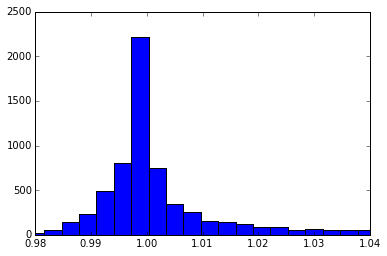

In [33]:
plt.hist(ratio[np.abs(ratio-1) > 0.0002], bins = 2000)
plt.xlim(0.98,1.04)

In [34]:
df0 = pd.DataFrame()

In [35]:
df0['revdisp'] = simulation.calculate('revdisp')

In [36]:
df0.shape

(42709, 1)

In [37]:
df = df0[df0.revdisp>0]

In [38]:
df.shape

(42147, 1)

In [39]:
ratio.shape

(42709,)

In [40]:
ratio[df0.revdisp>0].shape

(42147,)

In [41]:
df0['ratio'] = ratio[df0.revdisp>0]
df0['ratio_compensated'] = ratio_compensated[df0.revdisp>0]
df0["ratio_vickrey"] = ratio_vickrey[df0.revdisp>0]

df['ratio'] = ratio[df0.revdisp>0]
df['ratio_compensated'] = ratio_compensated[df0.revdisp>0]
df["ratio_vickrey"] = ratio_vickrey[df0.revdisp>0]

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-

In [42]:
df.shape

(42147, 4)

In [43]:
decile_of_disposable_income = df[df.revdisp>0].revdisp.quantile(np.arange(0,1.1,0.1)); print  decile_of_disposable_income
decile_of_disposable_income = np.array(decile_of_disposable_income)

0.0       212.000015
0.1     11948.551172
0.2     16175.014648
0.3     19594.308203
0.4     23299.548047
0.5     27839.919922
0.6     32657.760547
0.7     38018.407812
0.8     45054.846875
0.9     57273.193750
1.0    527534.312500
dtype: float64


In [44]:
decile_of_disposable_income[3]

19594.308203125001

In [45]:
print (df[(df.revdisp >= decile_of_disposable_income[0]) 
   & (df.revdisp < decile_of_disposable_income[1]) ].ratio>1.05).value_counts()
print (df[(df.revdisp >= decile_of_disposable_income[0]) 
   & (df.revdisp < decile_of_disposable_income[1]) ].ratio<0.95).value_counts()

False    4215
dtype: int64
False    4215
dtype: int64


In [46]:
(df[(df.revdisp >= decile_of_disposable_income[0]) 
       & (df.revdisp < decile_of_disposable_income[1]) ].ratio>1.05)


1        False
5        False
28       False
51       False
66       False
70       False
115      False
120      False
131      False
136      False
154      False
157      False
159      False
162      False
166      False
175      False
178      False
179      False
182      False
191      False
208      False
209      False
228      False
236      False
261      False
272      False
278      False
294      False
341      False
360      False
365      False
381      False
399      False
423      False
424      False
427      False
434      False
455      False
480      False
482      False
488      False
491      False
496      False
511      False
518      False
526      False
527      False
561      False
575      False
576      False
582      False
595      False
598      False
603      False
609      False
621      False
658      False
683      False
696      False
698      False
700      False
707      False
714      False
721      False
729      False
739      False
742      F

In [47]:
(df[(df.revdisp >= decile_of_disposable_income[0]) 
       & (df.revdisp < decile_of_disposable_income[1]) ].ratio>1.05)


1        False
5        False
28       False
51       False
66       False
70       False
115      False
120      False
131      False
136      False
154      False
157      False
159      False
162      False
166      False
175      False
178      False
179      False
182      False
191      False
208      False
209      False
228      False
236      False
261      False
272      False
278      False
294      False
341      False
360      False
365      False
381      False
399      False
423      False
424      False
427      False
434      False
455      False
480      False
482      False
488      False
491      False
496      False
511      False
518      False
526      False
527      False
561      False
575      False
576      False
582      False
595      False
598      False
603      False
609      False
621      False
658      False
683      False
696      False
698      False
700      False
707      False
714      False
721      False
729      False
739      False
742      F

In [48]:
import matplotlib.pyplot as plt

Les gains en money metric sont faible sur les premiers déciles car ils sont peu touchés par l'impôt sur le revenu, et donc un changement de celui-ci a peu d'impact.
Sur les déciles plus élevés ont voir que le gain augmente au fur à mesure que l'on monte dans les déciles. Ce qui semble en opposition avec le fait que les gains monétaires et d'utilités sont principalement du aux plus pauvres. C'est sans oublier que les gains en money metric sont une inversion du gains de la fonction d'utilité, et donc que pour un très riche un tout petit gain d'utilité nécessitera beaucoup d'argent, se traduisant par un gros gain en money metric ; tandis qu'un pauvre pourra avoir un gros gain d'utilité avec très peu d'argent (une réforme impliquant le passage de zéro à 1 euro de revenu disponible fait un gain infini d'utilité, mais impliquerait un gain en money metric d'uniquement 1 euros).

In [49]:
    hatch_dict = {1.05: "*", 1.1 : "/", 1.2 :"x" , 1.5 : "\\"}

In [50]:
{16 : 'hello', 18 :"goodbye"}

{16: 'hello', 18: 'goodbye'}

In [51]:
one_salaire_null = np.zeros(weight_individus.shape)
for month in range(1,13):
    one_salaire_null += (pd.Series(simulation.calculate("rev_sal_mensuel_times_12", "2009-{}".format(month)))<1)
one_salaire_null = one_salaire_null.astype("bool")
print pd.value_counts(one_salaire_null)

True     41728
False    38703
dtype: int64


In [52]:
salaire_not_null = (pd.Series(simulation.calculate_add("rev_sal"))>0); print salaire_not_null.value_counts()
chomage_not_null = (pd.Series(simulation.calculate_add("chomage_imposable"))>0); print chomage_not_null.value_counts()
retraite_not_null = (pd.Series(simulation.calculate_add("retraite_imposable"))>0); retraite_not_null.value_counts()

True     42639
False    37792
dtype: int64
False    73519
True      6912
dtype: int64


False    55394
True     25037
dtype: int64

In [53]:
print weight_individus.shape
print weight_foyers.shape
print weight_familles.shape
print weight_menages.shape

(80431,)
(52189,)
(48195,)
(42709,)


In [54]:
passage_retraite = salaire_not_null & retraite_not_null ; print passage_retraite.value_counts()
passage_chomage = salaire_not_null & chomage_not_null ; print passage_chomage.value_counts()
passage_cho_ret_emp = salaire_not_null & retraite_not_null & chomage_not_null ; print passage_cho_ret_emp.value_counts()
passage_cho_ret = retraite_not_null & chomage_not_null ; print passage_cho_ret.value_counts()
passage_cho_inact = salaire_not_null & one_salaire_null & ~retraite_not_null & ~chomage_not_null ; print passage_cho_inact.value_counts()


False    77501
True      2930
dtype: int64
False    73519
True      6912
dtype: int64
False    79846
True       585
dtype: int64
False    79846
True       585
dtype: int64
False    77781
True      2650
dtype: int64


In [55]:
changement_situation = retraite_not_null & chomage_not_null

In [56]:
df0['passage_retraite'] = sum_array_by_entity(passage_retraite,  'menage')
df0['passage_chomage'] = sum_array_by_entity(passage_chomage,  'menage')
#df['passage_retraite'] = sum_array_by_entity(passage_retraite,  'menage')
#df['passage_chomage'] = sum_array_by_entity(passage_chomage,  'menage')
#df0['passage_retraite'] = passage_retraite
#df0['passage_chomage'] = passage_chomage


/usr/local/lib/python2.7/site-packages/pandas/core/frame.py:1825: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


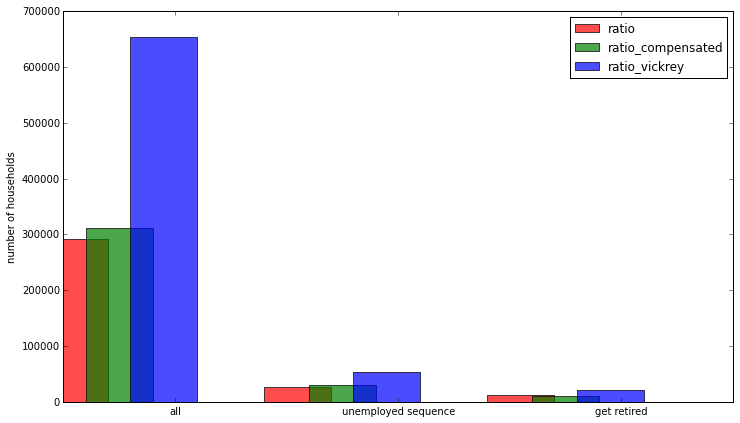

In [57]:
count = 0

fig, ax = plt.subplots(figsize = (12,7))
colo= ['r','g','b']
for var in ["ratio","ratio_compensated","ratio_vickrey"]:
    to_plot_array = list()
    
    
    to_plot_array.append(np.sum((df0[df0.revdisp >0][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0)]))
    
    condition = pd.Series(passage_chomage) & (df0.revdisp >0)
    condition0 = passage_chomage & (df0.revdisp >0)
    to_plot_array.append(np.sum((df0[condition ][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0) & condition0]))
    condition = passage_retraite
    condition0 = passage_retraite
    to_plot_array.append(np.sum((df0[condition ][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0) & condition0]))
    

    hello = ax.bar(0.4+ np.array(range(3))+count/5,to_plot_array,0.3, color = colo[count], alpha = 0.7, label = var)
    count +=1
plt.legend(loc = 0)
plt.xticks(np.arange(0,11, 1.0)) 
plt.yticks()
plt.ylabel("number of households")  
plt.xlim((0.5,3.5))
ax.set_xticklabels(('','all','unemployed sequence', 'get retired'))


In [58]:
passage_chomage.shape
df0.revdisp.shape
condition0.shape

(80431,)

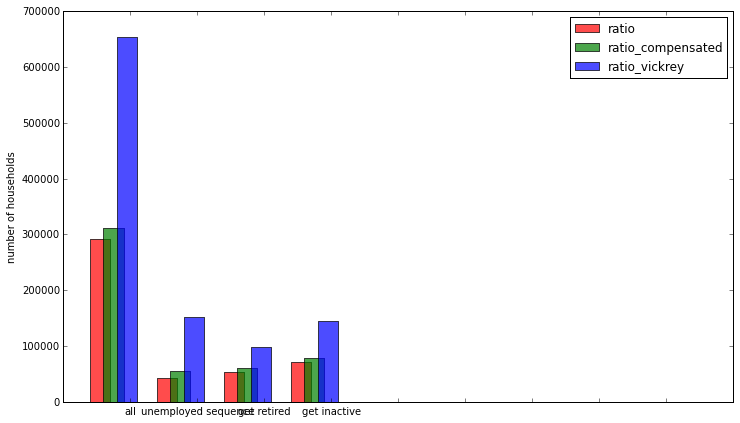

In [59]:
count = 0

fig, ax = plt.subplots(figsize = (12,7))
colo= ['r','g','b']
for var in ["ratio","ratio_compensated","ratio_vickrey"]:
    to_plot_array = list()
    
    
    to_plot_array.append(np.sum((df0[df0.revdisp >0][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0)]))
    
    condition = sum_array_by_entity(passage_chomage,  'menage').astype("bool") & (df0.revdisp >0)
    condition0 = sum_array_by_entity(passage_chomage,  'menage').astype("bool") & (df0.revdisp >0)
    to_plot_array.append(np.sum((df0[condition ][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0) & condition0]))
    condition = sum_array_by_entity(passage_retraite,  'menage').astype("bool")
    condition0 = sum_array_by_entity(passage_retraite,  'menage').astype("bool")
    to_plot_array.append(np.sum((df0[condition ][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0) & condition0]))
    condition = sum_array_by_entity(passage_cho_inact,  'menage').astype("bool")
    condition0 = sum_array_by_entity(passage_cho_inact,  'menage').astype("bool")
    to_plot_array.append(np.sum((df0[condition ][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0) & condition0]))
    

    hello = ax.bar(0.4+ np.array(range(4))+count/5,to_plot_array,0.3, color = colo[count], alpha = 0.7, label = var)
    count +=1
plt.legend(loc = 0)
plt.xticks(np.arange(0,11, 1.0)) 
plt.yticks()
plt.ylabel("number of households")  
#plt.xlim((0.5,3.5))
ax.set_xticklabels(('','all','unemployed sequence', 'get retired', 'get inactive'))


(3676, 6)
(80431,)
(3676, 6)
(80431,)
(3676, 6)
(80431,)


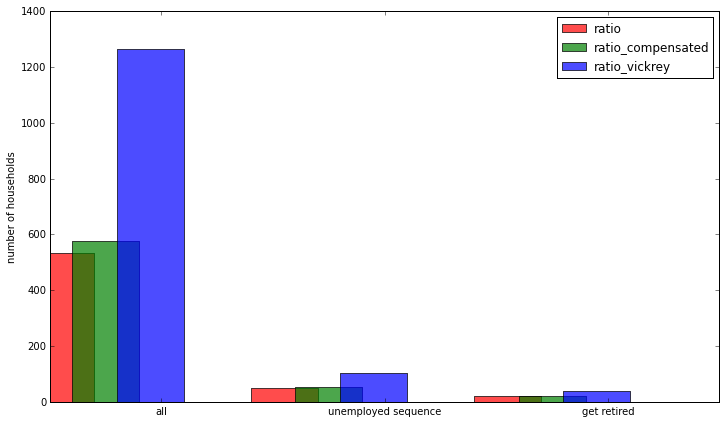

In [60]:
count = 0

fig, ax = plt.subplots(figsize = (12,7))
colo= ['r','g','b']
for var in ["ratio","ratio_compensated","ratio_vickrey"]:
    to_plot_array = list()
    
    
    to_plot_array.append(np.sum((df0[df0.revdisp >0][var]>1.05)))
    
    condition = passage_chomage & (df0.revdisp >0)
    condition0 = passage_chomage & (df0.revdisp >0)
    to_plot_array.append(np.sum((df0[condition ][var]>1.05)))
    print df0[condition].shape ; print condition.shape
    condition = passage_retraite
    condition0 = passage_retraite
    to_plot_array.append(np.sum((df0[condition ][var]>1.05)))
    

    hello = ax.bar(0.4+ np.array(range(3))+count/5,to_plot_array,0.3, color = colo[count], alpha = 0.7, label = var)
    count +=1
plt.legend(loc = 0)
plt.xticks(np.arange(0,11, 1.0)) 
plt.yticks()
plt.ylabel("number of households")
plt.xlim((0.5,3.5))
ax.set_xticklabels(('','all','unemployed sequence', 'get retired'))


17% du sample à un ratio différent de 1 soit 7309 personnes sur 42709 ; parmis eux 952 ont eu un passage à la retraite dans le ménage (33% des ménages ayant eu un passage à la retraite), et 622 un pagge au chomage(17%).

In [61]:
def serie(array):
    return pd.Series(array)

In [62]:
serie(ratio_vickrey>1).value_counts()

False    37817
True      4892
dtype: int64

In [63]:
rat_vickrey_sup_1_index = serie(simulation.calculate("revdisp"))[ratio_vickrey>1].index

In [64]:
serie(simulation.calculate("revdisp"))[ratio_vickrey>1]

0         36214.261719
3         46511.390625
24        62706.851562
40        47448.421875
52        20498.107422
53        24331.900391
63        17459.835938
83        20286.214844
84        65913.226562
108       23501.716797
117       47670.191406
118       22037.308594
123       30645.773438
125       44415.953125
147       36659.710938
149       18836.761719
151       23299.513672
152       44088.144531
156       33453.191406
169       25349.685547
172       37275.996094
176       19274.191406
212       19651.337891
217       48033.503906
243       36059.933594
250       43821.570312
258       63833.929688
269       81375.906250
280       44385.394531
282       30184.826172
284       24710.138672
286       26541.628906
292       87687.367188
299       36596.714844
334       16773.396484
343       32525.679688
356       28321.484375
357       14846.759766
361       57996.187500
366       36365.484375
382       51743.679688
384       63773.839844
387       17989.304688
400       5

In [65]:
df = pd.DataFrame()
for var in ['salaire', 'chomage', 'retraite']:
    for month in range(1,13):
        df['{}{}'.format(var, month)] = serie(sum_array_by_entity(simulation.calculate('{}_imposable'.format(var), "2009-{}".format(month)), 'menage'))

df['ratio_vickrey'] = ratio_vickrey
df['impo'] = simulation.calculate("impo")

In [66]:
df[(ratio_vickrey>1.001) & (passage_retraite|passage_chomage)].T

,286,343,361,485,495,885,896,954,1029,1047,1073,1099,1246,1344,1346,1371,1386,1406,1666,1750,1914,2006,2027,2032,2033,2226,2495,2507,2870,2879,2910,2914,2960,3068,3095,3109,3184,3236,3484,3490,3564,3584,3632,3637,3692,4103,4184,4290,4313,4513,4519,4597,4628,4650,4781,4837,4997,5064,5085,5136,5358,5540,5547,5658,5736,5762,5768,5777,5787,5816,5842,5880,5888,5974,6103,6320,6344,6473,6483,6577,6677,6774,6812,6829,6910,7034,7171,7199,7261,7356,7389,7402,7562,7579,7816,7901,7913,7957,8360,8399,...,33583,33707,33725,33786,33962,34059,34179,34254,34258,34436,34451,34645,34709,34721,34834,34904,35046,35129,35617,35619,35679,35776,35790,35822,35910,36009,36284,36295,36462,36745,36764,36944,36993,37070,37153,37271,37517,37631,37705,37730,37754,37786,37985,38005,38130,38324,38393,38540,38579,38628,38770,38887,38964,39000,39066,39118,39174,39390,39419,39483,39515,39633,39655,39663,39806,39829,39866,39964,40002,40202,40302,40310,40408,40748,40835,40919,41042,41095,41109,41127,41151,41643,41704,41705,41725,41753,41830,41831,41838,41848,41949,41970,42136,42139,42248,42277,42562,42574,42629,42654
salaire1,0.000000,2098.166748,2025.250000,6999.708252,0.000000,4168.583313,1987.000000,2238.500000,2294.083344,0.000000,2539.947021,1500.444458,0.000000,0.000000,3053.333252,1849.00000,455.083344,3332.783325,0.000000,0.000000,1850.516632,3447.444336,3224.250000,0.000000,0.000000,561.599976,6976.399902,0.000000,3693.800049,2244.333328,1662.500031,1513.250000,2397.083252,0.000000,2330.083252,5728.272949,4621.388977,0.000000,2355.250000,0.000000,0.000000,3593.697021,1413.666626,14.727273,0.000000,184.666672,3104.708374,76.833336,1381.666626,0.000000,0.000000,8882.099609,0.000000,3820.392822,0.000000,1580.818237,1177.428589,3784.750000,0.000000,681.272705,0.000000,0.000000,2015.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3542.250000,7793.666626,0.000000,30.833334,2690.285645,3904.349976,2543.333344,628.909119,0.000000,0.000000,0.000000,0.000000,1010.375000,6122.416748,1073.750000,0.000000,1638.699997,1088.285767,5997.833374,1190.333332,3489.583374,1929.250000,14557.000000,0.000000,0.000000,1724.099976,20671.726562,0.000000,1432.888916,2544.000000,1723.333374,0.000000,...,2486.125000,832.750000,3154.136353,0.000000,4781.916504,84.500000,4600.553223,1578.666626,4382.000000,0.000000,3462.125000,1960.428589,2205.666748,1363.833374,4540.749939,0.000000,1261.666626,1350.333374,1447.000000,2339.000000,3319.000000,337.777771,4471.199951,649.083313,3251.000000,311.833344,1700.000000,0.000000,0.000000,2615.166626,0.000000,1806.500000,0.000000,0.000000,3574.690430,4629.000000,3651.750000,1970.916626,1504.083293,0.000000,0.00000,0.000000,0.000000,5496.166748,0.000000,0.000000,1401.500000,6723.616699,0.000000,1595.000000,0.000000,6140.012024,6463.000000,325.333344,2581.916748,0.000000,116223.916504,0.000000,27.833334,0.000000,2061.666748,2646.916626,0.000000,1450.500000,932.333359,0.000000,2163.555664,0.000000,0.000000,0.000000,0.000000,103.333336,1696.083294,789.250000,1369.000000,0.000000,4371.816772,0.000000,0.000000,0.000000,3770.966736,3881.000000,0.000000,2220.000000,0.000000,0.000000,1675.714233,6011.199951,2787.000000,7407.727295,0.000000,1976.750041,4960.000000,2267.000000,0.000000,3660.249878,3907.388916,0.000000,4761.727295,1291.416626
salaire2,0.000000,2098.166748,1818.250000,6999.708252,0.000000,4168.583313,1987.000000,2238.500000,2294.083344,0.000000,2539.947021,1500.444458,0.000000,0.000000,3053.333252,1849.00000,455.083344,3332.783325,0.000000,1402.636353,1850.516632,3447.444336,3224.250000,0.000000,0.000000,561.599976,6976.399902,0.000000,3693.800049,2793.777786,1662.500031,1513.250000,2397.083252,0.000000,4451.355957,5728.272949,4621.388977,0.000000,2355.250000,0.000000,0.000000,3593.697021,1413.666626,14.727273,0.000000,1897.939377,3104.708374,76.833336,1381.666626,0.000000,0.000000,8882.099609,0.000000,3820.392822,0.000000,1580.818237,1177.428589,3784.750000,0.000000,681.272705,0.000000,0.000000,2015.000000,0.000000,0.000000,0.000000,0.0000

In [67]:
ratio_vickrey_individus = cast_array_from_entity_to_role(ratio_vickrey,'menage')

In [68]:
df = pd.DataFrame()
for var in ['salaire', 'chomage', 'retraite']:
    for month in range(1,13):
        df['{}{}'.format(var, month)] = simulation.calculate('{}_imposable'.format(var), "2009-{}".format(month))

df['ratio_vickrey_individus'] = ratio_vickrey_individus
df['impo'] = cast_array_from_entity_to_role(simulation.calculate("impo"),'menage')
df['passage_retraite'] = passage_retraite
df["passage_chomage"] = passage_chomage

In [69]:
df[df.ratio_vickrey_individus>1.001].T

,6,7,8,87,88,89,90,112,113,131,165,166,167,168,169,170,215,216,236,237,244,245,246,248,249,290,291,292,295,298,299,300,301,307,308,327,328,332,333,334,344,345,405,487,488,542,543,544,552,553,556,557,578,579,636,650,651,679,683,684,692,693,694,695,727,728,729,730,739,740,771,772,773,780,781,864,865,866,867,874,875,876,877,878,879,880,936,937,950,951,959,960,980,981,982,983,984,996,997,1014,...,79533,79534,79535,79549,79550,79555,79556,79557,79569,79570,79571,79572,79573,79574,79592,79593,79594,79628,79629,79644,79647,79648,79649,79650,79657,79658,79681,79682,79689,79699,79700,79732,79733,79739,79740,79741,79817,79839,79848,79849,79864,79865,79944,79945,79946,79956,79965,79966,80011,80012,80013,80032,80033,80050,80051,80053,80054,80107,80108,80109,80135,80136,80137,80138,80139,80140,80141,80142,80148,80189,80190,80191,80192,80193,80194,80252,80253,80271,80272,80280,80281,80289,80290,80291,80298,80299,80314,80315,80318,80319,80363,80364,80379,80380,80392,80394,80405,80406,80407,80429
salaire1,733.4,0,1413,0,2314.75,0,0,0,0,0,0,2809.75,1241.667,2219.667,0,0,0,1279.5,0,0,1607.25,0,0,0,0,524.8182,0,1236.667,0,0,2663.572,0,2505.143,0,583.8333,0,0,0,0,0,274.6667,0,1519.182,627.8333,0,2005.25,183.4167,0,0,34.75,0,0,2210.1,1351.417,0,0,2098.167,1468.125,207,1818.25,864.4167,7550.333,0,0,1728.75,0,0,0,1969.5,0,1.25,2907.667,0,0,0,0,0,0,0,3354.5,1798.167,1368.5,2523.75,0,4914.364,1756.818,3713.625,3286.083,0,0,817.5,1437.917,0,1972,1639,3204.143,0,0,0,2711.083,...,100.9167,0,1497.917,0,0,1953.636,2300.417,0,0,1603.917,2056.333,0,0,0,1319.917,1793.333,0,1448.5,3337.917,0,0,0,91.08334,0,1432.333,0,0,0,4790,0,2424.167,2477.083,0,0,0,1121.111,0,0,1725.75,1149.273,4099.667,0,0,0,1807.667,0,0,0,2308,120,1468,0,2108.333,0,0,2796.5,1351.167,2625.5,863.8889,418,0,0,0,0,0,0,0,0,1400,0,0,0,0,2108.5,818,2872,1889.727,0,831.8,555.5555,1087.167,0,0,0,1291.417,0,2888.25,2462,0,2378.333,0,1425.083,0,0,1493.375,0,0,877.5833,1596.667,0
salaire2,733.4,0,1413,0,2314.75,0,0,0,0,0,0,2809.75,1241.667,2219.667,0,0,0,1279.5,0,0,1607.25,0,0,0,0,524.8182,0,1236.667,0,0,2663.572,0,0,0,583.8333,0,0,0,0,0,0,935,1519.182,627.8333,0,2005.25,183.4167,0,0,34.75,0,0,0,1351.417,0,0,2098.167,1468.125,0,1818.25,864.4167,7550.333,0,0,1728.75,0,0,0,1969.5,0,1.25,2907.667,0,0,0,0,0,0,0,3354.5,1798.167,0,0,0,4914.364,1756.818,3713.625,3286.083,0,0,817.5,1437.917,0,1972,1639,3204.143,0,0,0,2711.083,...,100.9167,0,1497.917,0,0,0,2300.417,0,0,1603.917,2056.333,0,0,0,1319.917,1793.333,0,1448.5,3337.917,0,0,0,91.08334,0,1432.333,0,0,0,0,0,2424.167,2477.083,0,0,0,0,0,0,1725.75,1149.273,4099.667,0,0,0,1807.667,0,0,0,0,0,0,0,2108.333,0,0,2796.5,1351.167,2625.5,0,418,0,0,0,0,0,0,0,0,1400,0,0,0,0,2108.5,818,2872,1889.727,0,831.8,555.5555,1087.167,0,0,0,1291.417,0,2888.25,2462,0,2378.333,0,1425.083,0,0,1493.375,0,0,877.5833,1596.667,0
salaire3,0,0,1413,0,2314.75,0,0,0,0,0,0,2809.75,1241.667,0,0,0,0,1279.5,0,0,1607.25,1296.286,0,0,0,524.8182,0,1236.667,0,0,2663.572,0,0,0,583.8333,0,0,0,0,0,0,935,1519.182,627.8333,0,2005.25,183.4167,0,0,34.75,0,0,0,1351.417,0,0,2098.167,1468.125,0,1818.25,864.4167,7550.333,0,0,1728.75,0,0,0,1969.5,0,1.25,2907.667,0,0,0,0,0,0,0,0,1798.167,0,0,0,4914.364,1756.818,3713.625,3286.083,0,0,817.5,1437.917,0,1972,1639,3204.143,0,0,0,2711.083,...,100.9167,0,1497.917,0,0,1953.636,2300.417,0,0,1603.917,2056.333,0,0,0,1319.917,1793.333,0,1448.5,3337.917,0,0,0,91.08334,0,1432.333,0,0,0,0,0,2424.167,2477.083,0,0,0,0,0,0,1725.75,1149.273,4099.667,0,0,0,1807.667,0,0,0,0,120,1468,0,2108.333,0,0,2796.5,1351.167,2625.5,0,418,0,0,0,0,0,0,0,0,1400,0,0,0,0,2108.5,818,2872,1889.727,0,831.8,555.5555,1087.167,0,0,0,1291.417,0,2888.25,2462,0,2378.333,0,1425.083,0,0,1493.375,0,0,877.5833,1596.667,0
salaire4,0,0,1413,0,2314.75,1419.5,0,0,0,0,0,2809.75,1241.667,2219.667,0,0,0,1279.5,0,0,1607.25,1296.286,0,0,0,524.8182,0,1236.667,1996.333,0,2663.572,0,0,0,583.8333,0,0,0,0,0,0,935,1519.182,627.8333,0,2005.25,183.4167,0,0,34.75,0,0,2210.1,1351.417,0,0,2098.167,1468.125,0,1818.25,864.4167,0,0

In [123]:
un_seul_revenu = pd.Series(np.zeros(weight_individus.shape))
for var in ['salaire_imposable', 'chomage_imposable', 'retraite_imposable']:
    for month in range(1,13):
        un_seul_revenu += pd.Series(simulation.calculate('{}'.format(var), '2009-{}'.format(month))) != 0 

In [125]:
un_seul_revenu.isin([1,2,4])

0        False
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9        False
10       False
11       False
12       False
13       False
14        True
15       False
16       False
17       False
18       False
19       False
20       False
21       False
22       False
23       False
24       False
25       False
26       False
27       False
28       False
29       False
30       False
31       False
32       False
33       False
34       False
35       False
36       False
37       False
38       False
39       False
40       False
41       False
42       False
43       False
44       False
45       False
46       False
47       False
48       False
49       False
50       False
51       False
52       False
53       False
54       False
55       False
56       False
57       False
58       False
59       False
60       False
61       False
62       False
63       False
64       False
65       False
66       F

In [113]:
pd.value_counts(un_seul_revenu)

12    54735
0     15685
24     3886
1       748
11      716
9       581
10      515
3       482
4       462
6       451
8       389
2       368
7       357
5       341
36      120
23       72
22       65
21       63
20       63
16       62
13       57
15       56
18       43
17       34
19       33
14       32
28        4
35        2
26        2
29        1
30        1
31        1
32        1
33        1
34        1
27        1
dtype: int64

In [118]:
type(un_seul_revenu[0])

numpy.float64

In [126]:
un_seul_revenu.isin([12,0,24]).value_counts()

True     74306
False     6125
dtype: int64

In [119]:
pd.value_counts((pd.Series(un_seul_revenu) == 12)|
                (pd.Series(un_seul_revenu) == 0)|
                (pd.Series(un_seul_revenu) == 24))

True     74306
False     6125
dtype: int64

In [99]:
agedf = pd.DataFrame({'nombre_revenus' : un_seul_revenu,
              "age" : simulation.calculate("age")  
    })

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1bea0b690>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c060c0d0>]], dtype=object)

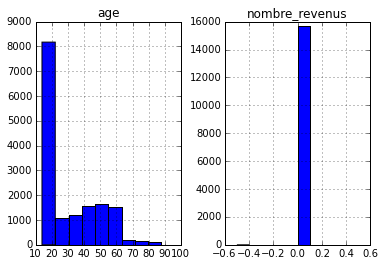

In [101]:
agedf[agedf.nombre_revenus == 0].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1bf04b190>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1bfe80e90>]], dtype=object)

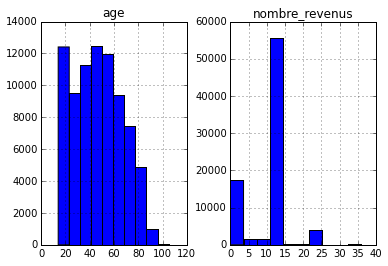

In [102]:
agedf.hist()

In [104]:
df = pd.DataFrame()
for var in ['salaire', 'chomage', 'retraite']:
    for month in range(1,13):
        df['{}{}'.format(var, month)] = simulation.calculate('{}_imposable'.format(var), "2009-{}".format(month))


In [127]:
df[un_seul_revenu == 24].head()

,salaire1,salaire2,salaire3,salaire4,salaire5,salaire6,salaire7,salaire8,salaire9,salaire10,salaire11,salaire12,chomage1,chomage2,chomage3,chomage4,chomage5,chomage6,chomage7,chomage8,chomage9,chomage10,chomage11,chomage12,retraite1,retraite2,retraite3,retraite4,retraite5,retraite6,retraite7,retraite8,retraite9,retraite10,retraite11,retraite12
28,2360.666748,2360.666748,2360.666748,2360.666748,2360.666748,2360.666748,2360.666748,2360.666748,2360.666748,2360.666748,2360.666748,2360.666748,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
78,552.166687,552.166687,552.166687,552.166687,552.166687,552.166687,552.166687,552.166687,552.166687,552.166687,552.166687,552.166687,137.416672,137.416672,137.416672,137.416672,137.416672,137.416672,137.416672,137.416672,137.416672,137.416672,137.416672,137.416672,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
79,392.083344,392.083344,392.083344,392.083344,392.083344,392.083344,392.083344,392.083344,392.083344,392.083344,392.083344,392.083344,567.666687,567.666687,567.666687,567.666687,567.666687,567.666687,567.666687,567.666687,567.666687,567.666687,567.666687,567.666687,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
94,5057.250000,5057.250000,5057.250000,5057.250000,5057.250000,5057.250000,5057.250000,5057.250000,5057.250000,5057.250000,5057.250000,5057.250000,2413.416748,2413.416748,2413.416748,2413.416748,2413.416748,2413.416748,2413.416748,2413.416748,2413.416748,2413.416748,2413.416748,2413.416748,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
97,622.333313,622.333313,622.333313,622.333313,622.333313,622.333313,622.333313,622.333313,622.333313,622.333313,622.333313,622.333313,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,826.583313,826.583313,826.583313,826.583313,826.583313,826.583313,826.583313,826.583313,826.583313,826.583313,826.583313,826.583313


## Nouvelle définition des passages.

In [ ]:
passage_retraite = salaire_not_null & retraite_not_null ; print passage_retraite.value_counts()
passage_chomage = salaire_not_null & chomage_not_null ; print passage_chomage.value_counts()
passage_cho_ret_emp = salaire_not_null & retraite_not_null & chomage_not_null ; print passage_cho_ret_emp.value_counts()
passage_cho_ret = retraite_not_null & chomage_not_null ; print passage_cho_ret.value_counts()
passage_cho_inact = salaire_not_null & one_salaire_null & ~retraite_not_null & ~chomage_not_null ; print passage_cho_inact.value_counts()


In [160]:
last_salaire = np.zeros(weight_individus.shape)
last_chomage = np.zeros(weight_individus.shape)
entree_chomage = np.zeros(weight_individus.shape)
sortie_chomage = np.zeros(weight_individus.shape)
last_retraite = np.zeros(weight_individus.shape)
passage_retraite = np.zeros(weight_individus.shape)
passage_inactif = np.zeros(weight_individus.shape)
for month in range(1,13):
    salaire = simulation.calculate('salaire_imposable', '2009-{}'.format(month))
    diff_salaire =  salaire - last_salaire
    chomage = simulation.calculate('chomage_imposable', '2009-{}'.format(month))
    diff_chomage =  chomage - last_chomage
    retraite = simulation.calculate('retraite_imposable', '2009-{}'.format(month))
    diff_retraite =  retraite - last_retraite
    
    
    entree_chomage += (diff_chomage>1) & (diff_salaire < -1)
    sortie_chomage += (diff_chomage<-1) & (diff_salaire > 1)
    
    passage_retraite += (diff_retraite> 1 ) & (diff_salaire < 1)
    passage_inactif += (diff_chomage == 0) & (diff_salaire >1)
    
    last_salaire = simulation.calculate('salaire_imposable', '2009-{}'.format(month))
    last_chomage = simulation.calculate('chomage_imposable', '2009-{}'.format(month))
    last_retraite = simulation.calculate('retraite_imposable', '2009-{}'.format(month))

In [161]:
pd.value_counts(sortie_chomage)

0    78473
1     1636
2      286
3       32
4        4
dtype: int64

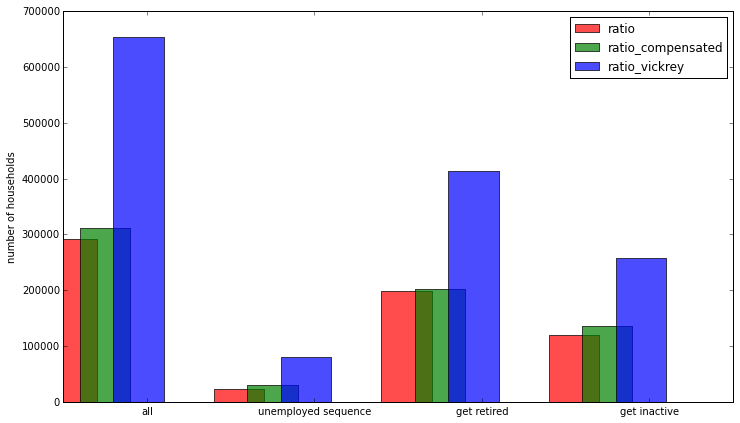

In [179]:
count = 0

fig, ax = plt.subplots(figsize = (12,7))
colo= ['r','g','b']
for var in ["ratio","ratio_compensated","ratio_vickrey"]:
    to_plot_array = list()
    
    
    to_plot_array.append(np.sum((df0[df0.revdisp >0][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0)]))
    
    condition = (sum_array_by_entity(entree_chomage,  'menage').astype("bool") | sum_array_by_entity(sortie_chomage,  'menage').astype("bool")) & (df0.revdisp >0)
    to_plot_array.append(np.sum((df0[condition ][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0) & condition]))
    
    
    condition = sum_array_by_entity(passage_retraite,  'menage').astype("bool")
    to_plot_array.append(np.sum((df0[condition ][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0) & condition]))
    condition = (sum_array_by_entity(passage_inactif,  'menage').astype("bool")) & ~(sum_array_by_entity(entree_chomage,  'menage').astype("bool") | sum_array_by_entity(sortie_chomage,  'menage').astype("bool"))

    to_plot_array.append(np.sum((df0[condition ][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0) & condition]))
    

    hello = ax.bar(0.4+ np.array(range(4))+count/5,to_plot_array,0.3, color = colo[count], alpha = 0.7, label = var)
    count +=1
plt.legend(loc = 0)
plt.xticks(np.arange(0,11, 1.0)) 
plt.yticks()
plt.ylabel("number of households")  
plt.xlim((0.5,4.5))
#plt.ylim((0,100000))
ax.set_xticklabels(('','all','unemployed sequence', 'get retired', 'get inactive'))


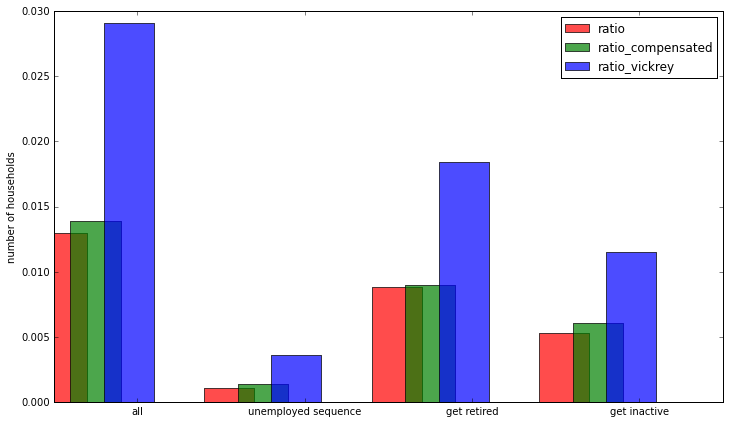

In [184]:
count = 0

fig, ax = plt.subplots(figsize = (12,7))
colo= ['r','g','b']
for var in ["ratio","ratio_compensated","ratio_vickrey"]:
    to_plot_array = list()
    
    
    to_plot_array.append(np.sum((df0[df0.revdisp >0][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0)]))
    
    condition = (sum_array_by_entity(entree_chomage,  'menage').astype("bool") | sum_array_by_entity(sortie_chomage,  'menage').astype("bool")) & (df0.revdisp >0)
    to_plot_array.append(np.sum((df0[condition ][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0) & condition]))
    
    
    condition = sum_array_by_entity(passage_retraite,  'menage').astype("bool")
    to_plot_array.append(np.sum((df0[condition ][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0) & condition]))
    condition = (sum_array_by_entity(passage_inactif,  'menage').astype("bool")) & ~(sum_array_by_entity(entree_chomage,  'menage').astype("bool") | sum_array_by_entity(sortie_chomage,  'menage').astype("bool"))

    to_plot_array.append(np.sum((df0[condition ][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0) & condition]))
    
    to_plot_array = pd.Series(to_plot_array)/(pd.Series(weight_menages)[(df0.revdisp >0)]).sum()

    hello = ax.bar(0.4+ np.array(range(4))+count/5,to_plot_array,0.3, color = colo[count], alpha = 0.7, label = var)
    count +=1
plt.legend(loc = 0)
plt.xticks(np.arange(0,11, 1.0)) 
plt.yticks()
plt.ylabel("number of households")  
plt.xlim((0.5,4.5))
#plt.ylim((0,100000))
ax.set_xticklabels(('','all','unemployed sequence', 'get retired', 'get inactive'))

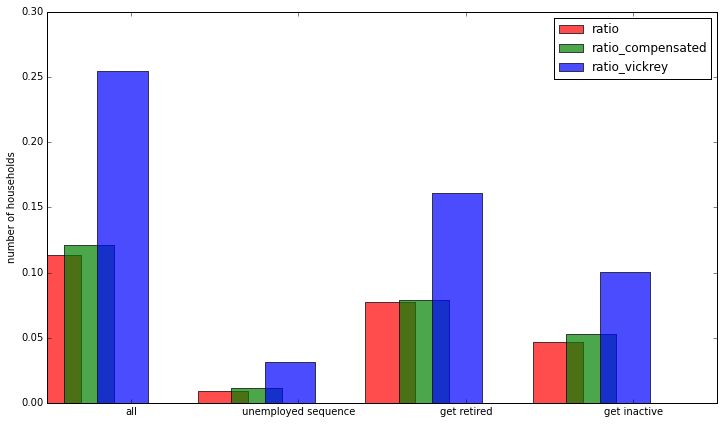

In [185]:
count = 0

fig, ax = plt.subplots(figsize = (12,7))
colo= ['r','g','b']
for var in ["ratio","ratio_compensated","ratio_vickrey"]:
    to_plot_array = list()
    
    
    to_plot_array.append(np.sum((df0[df0.revdisp >0][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0)]))
    
    condition = (sum_array_by_entity(entree_chomage,  'menage').astype("bool") | sum_array_by_entity(sortie_chomage,  'menage').astype("bool")) & (df0.revdisp >0)
    to_plot_array.append(np.sum((df0[condition ][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0) & condition]))
    
    
    condition = sum_array_by_entity(passage_retraite,  'menage').astype("bool")
    to_plot_array.append(np.sum((df0[condition ][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0) & condition]))
    condition = (sum_array_by_entity(passage_inactif,  'menage').astype("bool")) & ~(sum_array_by_entity(entree_chomage,  'menage').astype("bool") | sum_array_by_entity(sortie_chomage,  'menage').astype("bool"))

    to_plot_array.append(np.sum((df0[condition ][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0) & condition]))
    
    to_plot_array = pd.Series(to_plot_array)/(pd.Series(weight_menages)[(df0.ratio_vickrey >1)]).sum()

    hello = ax.bar(0.4+ np.array(range(4))+count/5,to_plot_array,0.3, color = colo[count], alpha = 0.7, label = var)
    count +=1
plt.legend(loc = 0)
plt.xticks(np.arange(0,11, 1.0)) 
plt.yticks()
plt.ylabel("number of households")  
plt.xlim((0.5,4.5))
#plt.ylim((0,100000))
ax.set_xticklabels(('','all','unemployed sequence', 'get retired', 'get inactive'))


In [182]:
to_plot_array

[291011.0, 23006.0, 198336.0, 118895.0]

In [136]:
df = {
    'get_retired': passage_retraite,
    'revdisp' : simulation.calculate("revdisp")    
}

In [129]:
print simulation.calculate("revdisp").shape
print ratio.shape
print pd.Series(ratio != 1).value_counts()
print pd.Series(ratio != 1)[passage_retraite].value_counts()
print pd.Series(ratio != 1)[passage_chomage].value_counts()
print 952+622

(42709,)
(42709,)
False    35400
True      7309
dtype: int64
False    1857
True      952
dtype: int64
False    1857
True      952
dtype: int64
1574


In [76]:
print simulation.calculate("revdisp").shape
print ratio.shape
print pd.Series(ratio != 1).value_counts(normalize = True)
print pd.Series(ratio != 1)[passage_retraite].value_counts(normalize = True)
print pd.Series(ratio != 1)[passage_chomage].value_counts(normalize = True)

(42709,)
(42709,)
False    0.828865
True     0.171135
dtype: float64
False    0.839974
True     0.160026
dtype: float64
False    0.832975
True     0.167025
dtype: float64


In [77]:
print simulation.calculate("revdisp").shape
print ratio.shape
print pd.Series(ratio > 1.002).value_counts()
print pd.Series(ratio > 1.002)[passage_retraite].value_counts()
print pd.Series(ratio > 1.002)[passage_chomage].value_counts()
print 952+622

(42709,)
(42709,)
False    40377
True      2332
dtype: int64
False    1453
True       78
dtype: int64
False    3513
True      211
dtype: int64
1574


In [78]:
print simulation.calculate("revdisp").shape
print ratio.shape
print pd.Series(ratio > 1.05).value_counts()
print pd.Series(ratio > 1.05)[passage_retraite].value_counts()
print pd.Series(ratio > 1.05)[passage_chomage].value_counts()
print 

(42709,)
(42709,)
False    42175
True       534
dtype: int64
False    1511
True       20
dtype: int64
False    3675
True       49
dtype: int64



In [79]:
Series_list = [simulation.calculate("revdisp_mensuel_annuel", "2009-{}".format(month)) for month in range(1,13)]

In [80]:
coucou = pd.DataFrame(Series_list).T

In [81]:
coucou.T*weight_menages

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,42609,42610,42611,42612,42613,42614,42615,42616,42617,42618,42619,42620,42621,42622,42623,42624,42625,42626,42627,42628,42629,42630,42631,42632,42633,42634,42635,42636,42637,42638,42639,42640,42641,42642,42643,42644,42645,42646,42647,42648,42649,42650,42651,42652,42653,42654,42655,42656,42657,42658,42659,42660,42661,42662,42663,42664,42665,42666,42667,42668,42669,42670,42671,42672,42673,42674,42675,42676,42677,42678,42679,42680,42681,42682,42683,42684,42685,42686,42687,42688,42689,42690,42691,42692,42693,42694,42695,42696,42697,42698,42699,42700,42701,42702,42703,42704,42705,42706,42707,42708
0,1279034.244141,377299.448456,409226.178955,2167523.540039,3752012.61084,365543.602295,980650.114136,315783.535156,5264081.784668,1875825.413086,1249912.839355,830285.76123,505328.625366,899078.794067,1086874.640991,-0.000000,551067.774902,1928627.209961,537593.074219,847800.75000,736094.384766,451560.785156,1051453.429199,1064202.015625,4891134.269531,2007025.493408,4628309.531250,1443145.634766,497827.882690,-0,690282.641968,549288.869019,463921.180298,758262.498779,696997.584229,797278.90918,878264.630127,710787.009521,854550.74707,1221040.878662,1419369.654785,1815615.151611,547663.990234,3746099.423828,768146.196289,613623.004761,387819.65625,1223456.25,4267492,1438998.257812,1289904.234375,205121.088745,299433.931732,2917338.736328,920560.824219,-0,1161031.269531,1602315.695068,1222054.703613,457307.446289,571051.535889,1213181.575928,577048.083252,3541349.266602,1314343.916016,1523059.492432,288514,937188.775879,190979.06604,-0,221474.706299,881484.000244,549013.797363,2733820.3125,567429.714355,826110.967773,545756.552246,877873.805420,3309144.71875,1943612.849609,4934176.757812,3973009.912109,588066.558105,1080426.744385,2412265.120117,1321112.006348,-0,386547.773438,611996.530762,855650,638897.458008,719567.797852,732392.523926,248359.771729,1360641.540527,1301619.750977,820592.147461,3458498.970215,2815615.590820,477927.59082,...,193146.246460,9738120.083984,1381789.124023,1077147.151855,163440.232910,121837.711304,511421.364868,5978335.347656,1732350.000,46148.205872,1396815.380859,1453946.723633,155125.743652,2672129.721680,980567.786133,492063.324463,4417153.256836,1786519.995117,0,889655.151245,1945870.900391,173366.971436,471638.056641,2699934.29126,1739471.567383,1983836.698242,1145888.978271,568126.847168,307915.236115,968761.429688,4714955.460205,0,647339.411865,2846140.782715,-0,910565.230957,1755841.569214,1096055.620605,303237.290527,2907734.63208,3582116.847656,302830.939453,1410188.493652,905700.285645,1284394.550537,726580.476562,566046.789551,1262083.064941,591926.003174,2757462.5,1394276.195068,850643.341309,1641450.291016,523158.278809,1778550.270020,2892988.010254,1586228.608643,966901.042969,2001171.8125,2543875.061035,407159.425049,411933.120605,0,446064.256897,2102062.133789,337347.967834,742603.182739,1191422.182983,242523.340576,656976.875,1086659.143066,0,1228347.451172,989741.771484,1086039.210938,1012650.9104,1028656.875,2849718.979980,1972354.103516,3090326.03125,613616.211914,564106.392578,887178.675537,2720179.479004,1313614.444336,584020.442139,2957027.25,425845.411621,146248.065552,770077.076660,3230441.288086,1116476.399414,494005.75,-0.000000,1021232.169922,3598310.259766,2669396.437500,689238.751953,899719.980469,92399.185997
1,1259077.117676,377299.448456,409226.178955,1706377.398682,3752012.61084,365543.602295,661655.141602,325491.687500,5264081.784668,1875829.699219,1249912.839355,830285.76123,505328.625366,899078.794067,1086874.640991,-0.000000,551067.774902,1928627.209961,440615.102295,890275.21875,736094.384766,451560.785156,1123066.714355,1020892.458008,4891134.269531,2007025.493408,4249196.303711

In [82]:
(pd.Series(simulation.calculate("revdisp")*weight_menages).sum()- (coucou.T*weight_menages).sum(1).sum())/10**9

43.28047812225342

In [83]:
print pd.Series(simulation.calculate("revdisp")*weight_menages).sum()/10**9
print (coucou.T*weight_menages).sum(1).sum()/10**9

721.589277388
678.308799266


In [84]:
to_plot_array

[1264, 105, 39]

In [85]:
(df0.revdisp>5500).value_counts()

True     41743
False      966
dtype: int64

In [86]:
2700*0.3 + 6000*0.14

1650.0

In [87]:
passage_retraite.value_counts()

False    77501
True      2930
dtype: int64

In [88]:
print df0.passage_chomage.value_counts(normalize=True)
print df0.passage_retraite.value_counts(normalize=True)
print df0.passage_chomage.value_counts()
print df0.passage_retraite.value_counts()

0    0.851928
1    0.134749
2    0.012948
3    0.000304
4    0.000070
dtype: float64
0    0.934229
1    0.062961
2    0.002786
3    0.000023
dtype: float64
0    36385
1     5755
2      553
3       13
4        3
dtype: int64
0    39900
1     2689
2      119
3        1
dtype: int64


In [89]:
passage_retraite = df0.passage_retraite.astype("bool")

print (ratio[passage_retraite] != 1).value_counts(normalize =True)
print (ratio_compensated[passage_retraite] != 1).value_counts(normalize =True)
print (ratio_vickrey[passage_retraite] != 1).value_counts(normalize =True)

False    0.661089
True     0.338911
dtype: float64
False    0.735493
True     0.264507
dtype: float64
False    0.677109
True     0.322891
dtype: float64


In [90]:
passage_chomage = df0.passage_retraite.astype("bool")

print (ratio[passage_retraite] != 1).value_counts(normalize =True)
print (ratio_compensated[passage_retraite] != 1).value_counts(normalize =True)
print (ratio_vickrey[passage_retraite] != 1).value_counts(normalize =True)

False    0.661089
True     0.338911
dtype: float64
False    0.735493
True     0.264507
dtype: float64
False    0.677109
True     0.322891
dtype: float64


In [91]:
df = pd.DataFrame()

In [92]:
#no_income_on_one_month

array = np.zeros(simulation.calculate("salaire_imposable").shape)
for month in range(1,13):

        retraite = pd.Series(simulation.calculate(var, '2009-{}'.format(month))==0)
        chomage = pd.Series(simulation.calculate(var, '2009-{}'.format(month))==0)
        salaire = pd.Series(simulation.calculate(var, '2009-{}'.format(month))==0)
        
        array += retraite & chomage & salaire







KeyError: 'retraite'

In [ ]:
pd.Series(array).value_counts()

In [ ]:
pd.Series(array).value_counts()

In [ ]:
# salaire_imposable_all_year

salaire = np.zeros(simulation.calculate("salaire_imposable").shape)
for month in range(1,13):
        salaire += (pd.Series(simulation.calculate("salaire_imposable", '2009-{}'.format(month)))>0)
# salaire_imposable_all_year

chomage = np.zeros(simulation.calculate("chomage_imposable").shape)
for month in range(1,13):
        chomage += (pd.Series(simulation.calculate("chomage_imposable", '2009-{}'.format(month)))>0)
retraite = np.zeros(simulation.calculate("retraite_imposable").shape)
for month in range(1,13):
        retraite += (pd.Series(simulation.calculate("retraite_imposable", '2009-{}'.format(month)))>0)
        
        

In [ ]:
pd.Series(salaire).value_counts()

In [ ]:
pd.Series(retraite).value_counts()

In [ ]:
pd.Series(chomage).value_counts()

In [ ]:
var

In [ ]:
(pd.Series(simulation.calculate_add('salaire_imposable'))>0).value_counts()

In [ ]:
pd.Series(array).value_counts()

In [ ]:
condition = (df.revdisp >= decile_of_disposable_income[decile]) & (df.revdisp < decile_of_disposable_income[decile+1])
condition0 = (df0.revdisp >= decile_of_disposable_income[decile]) & (df0.revdisp < decile_of_disposable_income[decile+1])
((df[condition ][var]>1.05)* pd.Series(weight_menages)[(df0.revdisp >0) & condition0])

In [ ]:
pd.Series(weight_menages)[(df0.revdisp >0) & condition0].shape

In [ ]:
df0.weight_familles[((df0.revdisp >0) & condition0)].shape

In [ ]:
hello = list()
hello.append(4) ; hello

In [ ]:
pd.Series(weight_familles).shape
(df.revdisp >0).shape

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

a = range(1,10)
b = range(4,13)
ind = np.arange(len(a))
width = 0.65

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(ind+width+0.35, b, 0.45, color='#deb0b0')

ax2 = ax.twinx()
ax2.bar(ind+width, a, width, color='#b0c4de')

ax.set_xticks(ind+width+(width/2))
ax.set_xticklabels(a)

ax.yaxis.set_ticks_position("right")
ax2.yaxis.set_ticks_position("left")

plt.tight_layout()
plt.show()

In [ ]:
decile_of_disposable_income[0]

# End selected for article

In [ ]:
for month in range(1,13):
    gain_u = (pd.Series(
     survey_scenario.simulation.calculate("utility_ir_mensuel_rsa_mensuel", "2009-{}".format(month)) - 
survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        ))
    gain_m =  (
        survey_scenario.simulation.calculate("inverted_utility_compenstaed_ir_mensuel_rsa_mensuel", "2009-{}".format(month)) - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))
    pd.DataFrame({'gain_utilite':gain_u, 'gain_argent':gain_m})
    plt.figure()
    pd.Series(gain_m)[(gain_m!=0)&(np.abs(gain_m)<300)].hist(bins = 100)
    #pd.Series(gain_m)[(gain_m!=0)].hist(bins = 1500)
    #print pd.Series(gain_m)[gain_m!=0].shape
    plt.xlim(-300,300)
    plt.xlabel("equivalent monetary gains in euros ")
    plt.ylabel('frequency')
#TODO: problème sur les 3 derniers mois !

In [ ]:
fig = plt.figure(figsize=(10, 9))
ax1 = plt.subplot2grid((2,2), (0,0), colspan=2)

ax1.plot(range_to_use,income_rep_func)




ax2 = plt.subplot2grid((2,2), (1,0), colspan=1)
ax2.plot(range_to_use,income_rep_func_f)
ax3 = plt.subplot2grid((2,2), (1,1), colspan=2)
ax3.plot(range_to_use,income_rep_func_m)


In [ ]:
sum_array_by_entity(month_income, 'menage')

In [ ]:
sum_array_by_entity(month_income, 'menage')

In [ ]:
plt.subplots()

In [ ]:
decote = simulation.calculate('decote')
decote_mensuel = simulation.calculate_add('decote_mensuel_times_12')/12


has_decote_difference = (np.abs(decote -decote_mensuel)>0.1).astype(bool)
has_decote_difference = cast_array_from_entity_to_role(has_decote_difference, 'foyer_fiscal', roles = [0])

fam_has_decote_diff = sum_array_by_entity(has_decote_difference, 'famille')

print pd.value_counts(fam_has_decote_diff)


#utility_loss = condition((u_c_ir - u_ir_a)<-0.00000001)
#utility_loss = cast_array_from_entity_to_role(utility_loss, roles = [0])


##### weights

In [ ]:
weight_foyers = survey_scenario.simulation.calculate_add('weight_foyers', period = period).astype(float)
weight_menages = survey_scenario.simulation.calculate_add('wprm', period = period).astype(float)
weight_familles = survey_scenario.simulation.calculate_add('weight_familles', period = period).astype(float)
weight_individus = survey_scenario.simulation.calculate_add('weight_individus', period = period).astype(float)

In [ ]:
print weight_foyers.shape , "foyers fiscaux"
print weight_menages.shape , "ménages"
print weight_familles.shape, "familles"
print weight_individus.shape, "individus"

In [ ]:
print weight_foyers.sum() , "foyers fiscaux"
print weight_menages.sum() , "ménages"
print weight_familles.sum(), "familles"
print weight_individus.sum(), "individus"

In [ ]:
variable = 'revdisp_mensuel_ir_mensuel'
monthly_df = pd.DataFrame(
                dict((column_name+"_"+period, survey_scenario.simulation.calculate_add(column_name, period)) 
                for period in ['{}-{}'.format( 2009, str(month).zfill(2)) for month in range(1, 13)] for column_name in [variable]) #TODO mensualize : allow for periods
                )
#monthly_df.T

In [ ]:
#monthly_df.T
monthly_df['revdisp_mensuel_ir_mensuel_2009-09'].mean()

In [ ]:
survey_scenario.compute_aggregate('revdisp_mensuel_annuel')/27000000

In [ ]:
survey_scenario.compute_aggregate('revdisp_mensuel_ir_mensuel')/27000000

In [ ]:
survey_scenario.compute_aggregate('revdisp_mensuel_ir_mensuel')/27000000

#### Pourcentage du sample entre -20 et 20

In [ ]:
lambda_compensation = pd.Series(survey_scenario.simulation.calculate("lambda_compensation"))
lambda_compensation.loc[(lambda_compensation == -np.inf)|lambda_compensation.isnull()]=0
lambda_compensation.loc[(lambda_compensation == np.inf)|lambda_compensation.isnull()]=0
prct1 = lambda_compensation[np.abs(lambda_compensation)>70].shape[0]/lambda_compensation.shape[0]
print "{} % du sample à un lambda supérieur  à 70 ".format(round(prct1,2)*100)

#### Lambda compensation négatif du à la décote ?

In [ ]:
pd.Series(survey_scenario.simulation.calculate_add("decote_mensuel_times_12")/12).mean()

In [ ]:
decote_monthly = pd.Series(survey_scenario.simulation.calculate_add("decote_mensuel_times_12")/12)
decote_annual =  pd.Series(survey_scenario.simulation.calculate_add("decote"))

In [ ]:
filtre_unequal_decote = decote_monthly != decote_annual

In [ ]:
lambda_compensation[filtre_unequal_decote].shape

In [ ]:
lambda_compensation[filtre_unequal_decote&
                    (np.abs(lambda_compensation)>.1)&
                    (np.abs(lambda_compensation)<100)].hist(bins = 500)
plt.xlim(-20,20)

In [ ]:
graph_filter = filtre_unequal_decote & (np.abs(lambda_compensation)>.1) & (np.abs(lambda_compensation)<100)


to_graph_foyer = lambda_compensation[graph_filter]
poids = pd.Series(weight_foyers)[graph_filter]

plt.figure(figsize=(15,10))
plt.hist(to_graph_foyer.values, bins = 100, weights = poids.values)
plt.xlabel(r'$\lambda$',fontsize = 20 )
plt.ylabel('Headcount',fontsize = 17)

In [ ]:
graph_filter = filtre_unequal_decote & (np.abs(lambda_compensation)>.1)&(np.abs(lambda_compensation)<100)


to_graph_foyer = lambda_compensation[filtre_unequal_decote&
                    (np.abs(lambda_compensation)>.1)&
                    (np.abs(lambda_compensation)<100)]
poids = pd.Series(weight_foyers)[
        filtre_unequal_decote&
        (np.abs(lambda_compensation)>.1)&
        (np.abs(lambda_compensation)<100)]

plt.figure(figsize=(15,10))
plt.hist(to_graph_foyer.values, bins = 100, weights = poids.values)
plt.xlabel(r'$\lambda$',fontsize = 20 )
plt.ylabel('Headcount',fontsize = 17)

In [ ]:
#weights = np.ones_like(myarray)/float()


In [ ]:
lambda_compensation = survey_scenario.simulation.calculate("lambda_compensation", period.this_year)
nb_parts_list = [1,1.5,2,2.5,3,4]
graph_filter = (np.abs(lambda_compensation)>.1)&(np.abs(lambda_compensation)<100)

nb_subplots_lines = len(nb_parts_list)//2 + len(nb_parts_list)%2 

fig, ax = plt.subplots(nb_subplots_lines,2,sharey = True, figsize = (20, 15), tight_layout = True)
count = 0
for parts in nb_parts_list:
    graph_filter = (np.abs(lambda_compensation)>.001)&(np.abs(lambda_compensation)<100) & (simulation.calculate('nbptr') == parts)
    i = count//2
    j = count %2
    
    ax[i,j].hist(lambda_compensation[graph_filter].values, bins = 100, normed = True)#, weights = poids.values)
    ax[i,j].set_xlabel(r'$\lambda$',fontsize = 20 )
    ax[i,j].set_ylabel('Headcount',fontsize = 17)
    ax[i,j].set_title('{} fiscal shares'.format(parts))
    ax[i,j].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
    ax[i,j].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
    ax[i,j].grid(which = 'both')
    count +=1
plt.savefig("image_result_of_mensualisation/lambda_compensation_by_fiscal_shares.png")

In [ ]:
lambda_compensation_menage = pd.Series(switch_entity('lambda_compensation', 'menage'))
graph_filter_menage =  (np.abs(lambda_compensation_menage)>.1)&(np.abs(lambda_compensation_menage)<100)

In [ ]:
to_graph_foyer = lambda_compensation[graph_filter]
poids_menage = pd.Series(weight_menages)[graph_filter_menage]

plt.figure(figsize=(15,10))
plt.hist(to_graph_foyer.values, bins = 100, weights = poids.values)
plt.xlabel(r'$\lambda$',fontsize = 20 )
plt.ylabel('Headcount',fontsize = 17)

In [ ]:
from matplotlib.ticker import AutoMinorLocator
nb_minor_ticks = 5
fig, ax = plt.subplots(1,2,sharey = True, figsize = (20, 7), tight_layout = True)

to_graph_menage = lambda_compensation_menage[graph_filter_menage]
poids_menage = pd.Series(weight_menages)[graph_filter_menage]


ax[0].hist(to_graph_foyer.values, bins = 100, weights = poids.values)
ax[0].set_xlabel(r'$\lambda$',fontsize = 20 )
ax[0].set_ylabel('Headcount',fontsize = 17)
ax[0].set_title('Fiscal Household')
ax[0].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[0].grid(which = 'both')



ax[1].hist(to_graph_menage.values, bins = 100, weights = poids_menage.values)
ax[1].set_xlabel(r'$\lambda$',fontsize = 20)
#ax[1].set_ylabel('Headcount',fontsize = 17)
ax[1].set_title('Household')
ax[1].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[1].grid(which = 'both')

In [ ]:
from matplotlib.ticker import AutoMinorLocator
nb_minor_ticks = 5
fig, ax = plt.subplots(1,2,sharey = True, figsize = (20, 7), tight_layout = True)

to_graph_menage = lambda_compensation_menage[graph_filter_menage]
poids_menage = pd.Series(weight_menages)[graph_filter_menage]
ax_nb = 0
ax[ax_nb].hist(to_graph_foyer.values, bins = 100,normed = True, weights = poids.values)
ax[ax_nb].set_xlabel(r'$\lambda$',fontsize = 20 )
ax[ax_nb].set_ylabel('Headcount',fontsize = 17)
ax[ax_nb].set_title('Fiscal Household')
ax[ax_nb].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[ax_nb].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[ax_nb].grid(which = 'both')


ax_nb = 1
ax[ax_nb].hist(to_graph_menage.values, bins = 100, normed = True ,weights = poids_menage.values)
ax[ax_nb].set_xlabel(r'$\lambda$',fontsize = 20)
#ax[1].set_ylabel('Headcount',fontsize = 17)
ax[ax_nb].set_title('Household')
ax[ax_nb].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[ax_nb].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[ax_nb].grid(which = 'both')

In [ ]:
index_exceptional_lambda = lambda_compensation[np.abs(lambda_compensation)>100].index

In [ ]:
df = survey_scenario.create_data_frame_by_entity_key_plural(['decote_gain_fiscal','decote_gain_fiscal_mensuel_times_12',"irpp",'irpp_mensuel', 'lambda_compensation'])['foyers_fiscaux']
df['decote_gain_fiscal_mensuel'] = df.decote_gain_fiscal_mensuel_times_12/12
df.iloc[index_exceptional_lambda]

In [ ]:
survey_scenario.simulation.calculate("irpp_mensuel","2009-08")[4]

In [ ]:
df["difference"] = np.abs(df.decote_gain_fiscal- df.decote_gain_fiscal_mensuel)>0.01
df[lambda_compensation == -12].difference.value_counts()

In [ ]:
df.shape

In [ ]:
df[lambda_compensation == -12][['decote_gain_fiscal', 'decote_gain_fiscal_mensuel', 'lambda_compensation',"irpp",'irpp_mensuel' ]]

In [ ]:
df = survey_scenario.create_data_frame_by_entity_key_plural(['decote_gain_fiscal','decote_gain_fiscal_mensuel_times_12',"irpp",'irpp_mensuel', 'lambda_compensation'])['foyers_fiscaux']
df.decote_gain_fiscal_mensuel_times_12 = df.decote_gain_fiscal_mensuel_times_12/12
df.lambda_compensation[df.lambda_compensation>70] = 0 #autrement les histogrames prennent trois heures à grapher pour quelques observations
df.lambda_compensation[df.lambda_compensation< -70] = 0

In [ ]:
df[np.abs(df.decote_gain_fiscal-df.decote_gain_fiscal_mensuel_times_12)+1>0].shape

In [ ]:
df.lambda_compensation[(np.abs(df.decote_gain_fiscal-df.decote_gain_fiscal_mensuel_times_12)-1<0)
                      & (np.abs(df.lambda_compensation)>0.1)].hist(bins = 100)
plt.xlim(-20,20)

In [ ]:
df.lambda_compensation[(np.abs(df.decote_gain_fiscal-df.decote_gain_fiscal_mensuel_times_12)-0.1>0)
                      & (np.abs(df.lambda_compensation)>0.1)].mean()

In [ ]:
df[(np.abs(df.decote_gain_fiscal-df.decote_gain_fiscal_mensuel_times_12)-0.1>0)
                      & (np.abs(df.lambda_compensation)>0.1)]

In [ ]:
df[df.lambda_compensation<-1]

In [ ]:
df[df.lambda_compensation<-1][df.decote_gain_fiscal> df.decote_gain_fiscal_mensuel_times_12]

## Compensated irpp

In [ ]:
print max(pd.Series(survey_scenario.simulation.calculate_add('compensated_irpp_mensuel') -  survey_scenario.simulation.calculate_add('irpp')))
print min(pd.Series(survey_scenario.simulation.calculate_add('compensated_irpp_mensuel') -  survey_scenario.simulation.calculate_add('irpp')))

In [ ]:
df = survey_scenario.create_data_frame_by_entity_key_plural(['decote_gain_fiscal','decote_gain_fiscal_mensuel_times_12',"irpp",'irpp_mensuel', 'lambda_compensation', 'compensated_irpp_mensuel'])['foyers_fiscaux']
df.decote_gain_fiscal_mensuel_times_12 = df.decote_gain_fiscal_mensuel_times_12/12
#df.lambda_compensation[df.lambda_compensation>70] = 0 #autrement les histogrames prennent trois heures à grapher pour quelques observations
#df.lambda_compensation[df.lambda_compensation< -70] = 0
#df.compensated_irpp_mensuel = df.compensated_irpp_mensuel
df

In [ ]:
df = survey_scenario.create_data_frame_by_entity_key_plural(['decote_gain_fiscal','decote_gain_fiscal_mensuel_times_12',"irpp",'irpp_mensuel', 'lambda_compensation', 'compensated_irpp_mensuel'])['foyers_fiscaux']
df.decote_gain_fiscal_mensuel_times_12 = df.decote_gain_fiscal_mensuel_times_12/12
#df.lambda_compensation[df.lambda_compensation>70] = 0 #autrement les histogrames prennent trois heures à grapher pour quelques observations
#df.lambda_compensation[df.lambda_compensation< -70] = 0
#df.compensated_irpp_mensuel = df.compensated_irpp_mensuel
df

In [ ]:
df[df.compensated_irpp_mensuel - df.irpp<2][['irpp', 'compensated_irpp_mensuel', 'irpp_mensuel']]

In [ ]:
print survey_scenario.compute_aggregate('compensated_irpp_mensuel')
print survey_scenario.compute_aggregate('irpp')

In [ ]:
impot_mensuel_times_12 = survey_scenario.simulation.calculate("irpp_mensuel", period)*12
lambda_compensation = survey_scenario.simulation.calculate("lambda_compensation", period.this_year)



compensated_irpp = impot_mensuel_times_12/(12 + lambda_compensation)

In [ ]:
compensated_irpp[743]

In [ ]:
(survey_scenario.simulation.calculate("irpp", period.this_year) == 0)*0

In [ ]:
compensated_irpp = (survey_scenario.simulation.calculate("irpp", period.this_year) == 0) * 0 + \
                ~(survey_scenario.simulation.calculate("irpp", period.this_year) == 0) * np.nan_to_num(compensated_irpp) ;compensated_irpp[[4,743]]

In [ ]:
compensated_irpp = (
                (survey_scenario.simulation.calculate_add("irpp_mensuel", period) == 0) * #Condition
                (survey_scenario.simulation.calculate("irpp", period.this_year)/12) # on répartit sur l'année
            ) + ~(survey_scenario.simulation.calculate_add("irpp_mensuel", period) == 0) * compensated_irpp #condition opposée
compensated_irpp[[4,743]]

In [ ]:
df[df.lambda_compensation.isnull()]

In [ ]:
survey_scenario.simulation.calculate_add('irpp')

In [ ]:
survey_scenario.compute_aggregate('compensated_irpp_mensuel')

In [ ]:
lambda_compensation = survey_scenario.simulation.calculate('lambda_compensation')
np.all(lambda_compensation != np.nan)
lambda_compensation != np.nan
hello = lambda_compensation[1]
assert np.all(np.isfinite(lambda_compensation))


In [ ]:
sal_pen_df = survey_scenario.create_data_frame_by_entity_key_plural_with_monthly_basis_selector(['irpp'], ['irpp_mensuel','compensated_irpp_mensuel'])['foyers_fiscaux']

sal_pen_df.T

In [ ]:
survey_scenario.compute_aggregate('compensated_irpp_mensuel')

## Utility annalysis 

In [ ]:
survey_scenario.compute_aggregate("utility_ir_annuel") #TODO : find why Nan

In [ ]:
print pd.Series(survey_scenario.simulation.calculate_add('utility_ir_annuel','2009')).mean()
print pd.Series(survey_scenario.simulation.calculate_add('utility_ir_mensuel','2009')).mean()
print pd.Series(survey_scenario.simulation.calculate_add('utility_compensated_ir_mensuel','2009')).mean()
print pd.Series(survey_scenario.simulation.calculate_add('utility_ir_mensuel_rsa_mensuel','2009')).mean()

In [ ]:
u_ir_m_rsa_m = pd.Series(survey_scenario.simulation.calculate_add('utility_ir_mensuel_rsa_mensuel','2009'))
u_c_ir = pd.Series(survey_scenario.simulation.calculate_add('utility_compensated_ir_mensuel','2009'))
u_ir_m = pd.Series(survey_scenario.simulation.calculate_add('utility_ir_mensuel','2009'))
u_ir_a = pd.Series(survey_scenario.simulation.calculate_add('utility_ir_annuel','2009'))


In [ ]:
print u_ir_m_rsa_m.mean(),1/u_ir_m_rsa_m.mean()
print u_c_ir.mean(),1/u_c_ir.mean()
print u_ir_m.mean(),1/u_ir_m.mean()
print u_ir_a.mean(),1/u_ir_a.mean()

In [ ]:
print u_c_ir.describe()
print u_ir_m.describe()
print u_ir_a.describe()

In [ ]:
print 1/u_c_ir.describe()
print 1/u_ir_m.describe()
print 1/u_ir_a.describe()

In [ ]:
((u_ir_m - u_ir_a)).hist(bins = 500, figsize = (25,12))
plt.ylim(0,200)

In [ ]:
((u_ir_m - u_ir_a)<-0.0000001).value_counts()

In [ ]:
((u_c_ir - u_ir_a)).hist(bins = 500, figsize = (25,12))
plt.ylim(0,200)

In [ ]:
((u_c_ir - u_ir_a)<-0.0000001).value_counts()

##### Graphs with weights

In [ ]:
((u_ir_m - u_ir_a)).hist(bins = 500, figsize = (25,12), zorder=1, alpha = 0.7, weights = weight_menages,)
((u_c_ir - u_ir_a)).hist(bins = 500, figsize = (25,12), weights = weight_menages,zorder=10, alpha = 1)
plt.ylim(0,5*10**4)
plt.xlabel('utility')
plt.ylabel('headcounts')

In [ ]:
hist1 = ((u_ir_m - u_ir_a)).hist(bins = 200, figsize = (25,12), weights = weight_menages, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
hist2 = ((u_c_ir - u_ir_a)).hist(bins = 200, figsize = (25,12), weights = weight_menages,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
plt.ylim(0,20*10**4)
plt.xlim(-0.0005, 0.0005)
plt.legend()
plt.title("Difference in utility w.r.t annual basis", size = 15)
plt.xlabel('utility')
plt.ylabel('headcounts')

In [ ]:
hist1 = ((u_ir_m - u_ir_a)).hist(bins = 3000, figsize = (25,12), weights = weight_menages, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
hist2 = ((u_c_ir - u_ir_a)).hist(bins = 3000, figsize = (25,12), weights = weight_menages,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
#plt.ylim(0,70*10**5)
plt.xlim(-0.00002, 0.00002)
plt.legend()
plt.title("Difference in utility w.r.t annual basis", size = 15)
plt.xlabel('utility')
plt.ylabel('headcounts')

In [ ]:
weight_menages = pd.Series(weight_menages)

In [ ]:
execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    hist1 = ((u_ir_m - u_ir_a))[((u_ir_m - u_ir_a))!=0].hist(bins = 7000, figsize = (25,12), weights = pd.Series(weight_menages)[((u_ir_m - u_ir_a))!=0].values, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_c_ir - u_ir_a))[((u_c_ir - u_ir_a))!=0].hist(bins = 7000, figsize = (25,12), weights = pd.Series(weight_menages)[((u_c_ir - u_ir_a))!=0].values,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

    plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,35*10**4)
    plt.xlim(-0.00002, 0.00002)
    plt.legend()
    plt.title("Difference in utility w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility', size = 15)
    plt.ylabel('headcounts', size = 15)

In [ ]:
outliers = pd.Series(np.abs(((u_ir_m - u_ir_a))[((u_ir_m - u_ir_a))!=0])>0.00002).value_counts(normalize = True); outliers

In [ ]:
"This graph represent {}% of the tax-unit with varying utility, {}% of that sample are over 0.0002 utility points variation".format(outliers[0], outliers[1])

In [ ]:
pd.Series(weight_menages).shape

In [ ]:
decote = survey_scenario.simulation.calculate('decote_menage')
decote_mensuel = survey_scenario.simulation.calculate_add('decote_mensuel_menage')

In [ ]:
(pd.Series(survey_scenario.simulation.calculate_add('revdisp_mensuel_annuel'))[((u_c_ir - u_ir_a)<0)]).hist(bins = 100)

In [ ]:
pay_irpp = (simulation.calculate('irpp') > 0)
print pay_irpp.shape
pd.value_counts(cast_array_from_entity_to_role(pay_irpp, 'foyer_fiscal', roles = [0]))

In [ ]:
decote_mensuel = simulation.calculate_add("decote_gain_fiscal_mensuel_times_12")/12
decote = simulation.calculate_add("decote_gain_fiscal")


has_decote_difference = (np.abs(decote -decote_mensuel)>0.1).astype(int)
has_decote_difference = cast_array_from_entity_to_role(has_decote_difference, 'foyer_fiscal', roles = [0])

nb_decote_diff_menage = sum_array_by_entity(has_decote_difference, 'menage')

print pd.value_counts(nb_decote_diff_menage)


utility_loss = (u_c_ir - u_ir_a)<-0.00000001
pd.value_counts(nb_decote_diff_menage[utility_loss])

#utility_loss = condition((u_c_ir - u_ir_a)<-0.00000001)
#utility_loss = cast_array_from_entity_to_role(utility_loss, roles = [0])


In [ ]:
revdisp_loss = (simulation.calculate_add('revdisp_mensuel_compensated_ir_mensuel') - simulation.calculate_add('revdisp_mensuel_annuel')) < -1
#no_decote_or_payment_threshold_concern =  
good_rev_trav = switch_entity('rfr', 'menage')/switch_entity('nbptr', 'menage') > 20000
pd.value_counts(pd.Series(revdisp_loss)[good_rev_trav])

In [ ]:
dico = {} #bizare, qu'est-ce qu'il se passe exactement ?
a = 7
for month in range(1,13):
    dico[month] = zip(pd.Series(simulation.calculate("revdisp_mensuel_compensated_ir_mensuel", period = "2009-{}".format(month)))[good_rev_trav&revdisp_loss][a:a+1], 
                      pd.Series(simulation.calculate_add('revdisp_mensuel_compensated_ir_mensuel') - simulation.calculate_add('revdisp_mensuel_annuel'))[good_rev_trav&revdisp_loss][a:a+1],
                      pd.Series(switch_entity('irpp', 'famille'))[good_rev_trav&revdisp_loss][a:a+1],
                      
                     
                     )

In [ ]:
dico

In [ ]:
good_rev_trav.shape

In [ ]:
pd.Series(nb_decote_diff_menage.astype('bool'))[utility_loss == True].value_counts(normalize = True) #Parmis les ménages ayant eu une perte d'utilité 56% ont eu une différence de décote.

In [ ]:
pd.Series(nb_decote_diff_menage.astype('bool'))[utility_loss == True].value_counts(normalize = True) #Parmis les ménages ayant eu une perte d'utilité 56% ont eu une différence de décote.

In [ ]:
(nb_decote_diff_menage.astype('bool')*weight_menages.values).sum()/weight_menages.sum()

In [ ]:
nb_decote_diff_menage

In [ ]:
pd.Series(utility_loss)[nb_decote_diff_menage.astype('bool')].value_counts(normalize = True) #Parmis les ménages ayant eu une différence de décote 5% ont eu une perte d'utilité

In [ ]:
pd.Series(nb_decote_diff_menage.astype('bool'))[utility_loss == True].value_counts()

In [ ]:
u_c_ir.shape

In [ ]:
pd.value_counts(sum_array_by_entity(has_decote_difference, 'menage'))

In [ ]:
ax = ((pd.Series(np.abs(decote -decote_mensuel)>0.1)[((u_c_ir - u_ir_a)<-0.00000001)]).value_counts( normalize = True)*100).plot(kind = "bar",)
plt.ylim((0,100))

labels = ["{}%".format(np.round(i,2)) for i in ((pd.Series(np.abs(decote -decote_mensuel)>0.1)[((u_c_ir - u_ir_a)<-0.0000001)]).value_counts( normalize = True)*100) ] #0.000001 pour éviter les erreurs d'arrondis.
rects = ax.patches

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

In [ ]:
survey_scenario.simulation.persons.count

In [ ]:
is_decote_different = pd.Series(np.abs(decote -decote_mensuel)>0.1)[((u_c_ir - u_ir_a)<-0.00000001)]

In [ ]:
#TODO for famille and check if it coorrespond to the 46.43%
below_collection_thrshld = np.zeros(weight_foyers.shape[0], dtype=bool)
for month in range(1,13):
    irpp_mensuel = pd.Series(survey_scenario.simulation.calculate("irpp_mensuel", '2009-{}'.format(month)))
    below_collection_thrshld += (irpp_mensuel>1) & (irpp_mensuel<5.16)
    

In [ ]:
pd.Series(below_collection_thrshld).value_counts()

In [ ]:
np.array([True, False])+np.array([True, True])

In [ ]:
#Qui sont les gagnants ? :


In [ ]:
is_decote_different[is_decote_different==False]

In [ ]:
pd.Series(np.abs(decote -decote_mensuel)>0.1)[((u_c_ir - u_ir_a)<0.000001)].value_counts(normalize = True)

In [ ]:
(pd.Series(decote!= decote_mensuel)[((u_c_ir - u_ir_a)<0)]).hist(bins = 100)

In [ ]:
revdisp[(u_c_ir>=u_ir_a)]

In [ ]:
print u_c_ir[(decote_annual==0) & (decote_monthly==0)].mean()
print u_ir_m[(decote_annual==0) & (decote_monthly==0)].mean()
print u_ir_a[(decote_annual==0) & (decote_monthly==0)].mean()

## Qui sont les gagnants ?

In [ ]:
print pd.value_counts((survey_scenario.simulation.calculate_add("revdisp_mensuel_annuel")-survey_scenario.simulation.calculate_add("revdisp_mensuel_ir_mensuel"))>1)
print pd.value_counts((survey_scenario.simulation.calculate_add("revdisp_mensuel_annuel")-survey_scenario.simulation.calculate_add("revdisp_mensuel_ir_mensuel"))<-1)

In [ ]:
print pd.Series(((survey_scenario.simulation.calculate_add("revdisp_mensuel_annuel")-survey_scenario.simulation.calculate_add("revdisp_mensuel_ir_mensuel"))>1)
                     *weight_menages).sum()
print pd.Series(((survey_scenario.simulation.calculate_add("revdisp_mensuel_annuel")-survey_scenario.simulation.calculate_add("revdisp_mensuel_ir_mensuel"))<-1)
                      *weight_menages).sum()

In [ ]:
np.mean(
    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")>1]
    )

In [ ]:
plt.figure(figsize=(15,10))
plt.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")>1], bins = 200, label = "Paying less on monthly basis")
plt.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")<-1], bins = 65, color= 'r', label = "Paying more on monthly basis")
plt.xlim(0,50000)
plt.title("paying more or less")

###### Weighted

In [ ]:
from openfisca_utils import make_ready_to_use_simulation
from openfisca_core import rates
simulation = make_ready_to_use_simulation.make_ready_to_use_simulation(2009,False)
rbg_test_case = simulation.calculate('rbg')
irpp_test_case = simulation.calculate('irpp')
marginal_rate = rates.marginal_rate(irpp_test_case, rbg_test_case)-1
to_change = pd.Series(marginal_rate)[marginal_rate>1].index
#to_change = pd.Series(rates.marginal_rate(irpp_test_case, rbg_test_case)-1)[rates.marginal_rate(irpp_test_case, rbg_test_case)-1>1].index
marginal_rate[to_change] = marginal_rate[to_change+1]
plt.plot(marginal_rate)

In [ ]:
to_change = pd.Series(rates.marginal_rate(irpp_test_case, rbg_test_case)-1)[rates.marginal_rate(irpp_test_case, rbg_test_case)-1>1].index


In [ ]:
pd.Series(marginal_rate)[marginal_rate>1]

In [ ]:
np.mean(survey_scenario.simulation.calculate("rbg"))

In [ ]:
np.array([True,True,False]) *np.array([2,3,4])

In [ ]:
pd.value_counts((survey_scenario.simulation.calculate_add("revdisp_mensuel_annuel") - survey_scenario.simulation.calculate_add("revdisp_mensuel_compensated_ir_mensuel")>1))

In [ ]:


weights1 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")>1]
weights2 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")<-1]

fig, ax1 = plt.subplots(figsize=(20, 10))


ax1.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))>1], bins = 400, label = "Paying more on monthly basis", weights= weights1)
ax1.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))<-1], bins = 130, color= 'r', label = "Paying less on monthly basis",weights= weights2)


ax1.set_xlim(0,50000)
ax2 = plt.twinx()
ax2.plot(rbg_test_case[1:],marginal_rate, 'k', label = "marginal tax rate")
ax2.set_xlim(0,50000)
ax2.legend()
ax1.legend(bbox_to_anchor=(0.22, 1))
ax1.grid(which = 'both')
ax1.text(11000,500000, u"minimum wage", weight = 'bold',)
ax2.set_ylabel("marginal tax rate")
ax1.set_xlabel("Gross global income divided by fiscal shares")
ax1.set_ylabel("number of taxunit")
#plt.title("")


In [ ]:
-(100 -  110)

In [ ]:
survey_scenario.simulation.calculate_add("irpp_mensuel").mean()

### Gains monetaires

#### Same annalysis with benefits

In [ ]:
survey_scenario.compute_aggregate("rsa_socle_majore_mensualise")

In [ ]:
survey_scenario.compute_aggregate("rsa_non_majore")

In [ ]:
pd.Series(survey_scenario.simulation.calculate("rsa_eligibilite_tns", "2009-01")).value_counts()

# Utilitarian monetary gains

In [ ]:
monetary_gain_ir = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    monetary_gain_ir += (
    survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )*weight_menages

In [ ]:
((monetary_gain_ir.sum(0)/10)*12)/10**9

Gains moyens par ménages.

In [ ]:
monetary_gain_ir = pd.Series(monetary_gain_ir)
monetary_gains_ir_0 = monetary_gain_ir[monetary_gain_ir != 0]
monetary_gains_ir_0.hist(bins = 500, weights = (pd.Series(weight_menages)[monetary_gain_ir != 0]).values)
plt.xlim(-10000,10000)

In [ ]:
print pd.Series(monetary_gain_ir<-10).value_counts()
print pd.Series(monetary_gain_ir>10).value_counts()
pd.Series(monetary_gain_ir)[monetary_gain_ir>10].shape

In [ ]:
month = 7
gain = pd.Series(survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )
gain[np.abs(gain)>1].mean()


In [ ]:
 diff_in_income = pd.Series(
    np.abs(survey_scenario.simulation.calculate("revdisp_mensuel_annuel", "2009-{}".format(month))
          - survey_scenario.simulation.calculate("revdisp_mensuel_compensated_ir_mensuel", "2009-{}".format(month)))>1
    )

In [ ]:
weight_menages.sum(0)

In [ ]:
#monetary_gain.sum(0)/10**9

#### Non compensated

In [ ]:
for month in range(1,13):
    gain_u = (pd.Series(
     survey_scenario.simulation.calculate("utility_ir_mensuel", "2009-{}".format(month)) - 
survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        ))
    gain_m =  (
        survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))
    pd.DataFrame({'gain_utilite':gain_u, 'gain_argent':gain_m})
    plt.figure()
    pd.Series(gain_m)[gain_m!=0].hist(bins = 1500)
    plt.xlim(-200,200)
    plt.xlabel("equivalent monetary gains in euros ")
    plt.ylabel('frequency')
#TODO: problème sur les 3 derniers mois !

In [ ]:
u_monetary_gain_ir = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    u_monetary_gain_ir += (
    survey_scenario.simulation.calculate("inverted_utility_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )*weight_menages

In [ ]:
((u_monetary_gain_ir.sum(0)/10)*12)/10**9

In [ ]:
u_monetary_gain_ir = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    u_monetary_gain_ir += np.mean(
    (survey_scenario.simulation.calculate("inverted_utility_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))*weight_menages
    )

In [ ]:
((u_monetary_gain_ir.sum(0)/10)*12)/10**9

In [ ]:
u_monetary_gain_ir = np.zeros(weight_menages.shape[0])
for month in range(1,12):
    u_monetary_gain_ir += (
    survey_scenario.simulation.calculate("inverted_utility_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )*weight_menages

In [ ]:
(u_monetary_gain_ir.sum(0))/10**9

In [ ]:
month = 6
gain = pd.Series(survey_scenario.simulation.calculate("inverted_utility_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )
mean_gain = gain[np.abs(gain)>1].mean()
print('{} gain on average'.format(mean_gain))

In [ ]:
u_monetary_gain = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    u_monetary_gain +=np.mean(
        pd.Series(survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))
               )
(((u_monetary_gain_ir/10)*12)/10**9).mean()  

#### mean monetary equivalent utility gain for each month

In [ ]:
u_money_gain = np.zeros(weight_menages.shape[0])
mean_gain = np.zeros(1)
for month in range(1,13):
    u_money_gain = pd.Series(survey_scenario.simulation.calculate("inverted_utility_ir_mensuel", "2009-{}".format(month)) - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
        )
    mean_gain += (u_money_gain[np.abs(u_money_gain)>1]).mean()
print('{} gain on average'.format(mean_gain[0]))

In [ ]:
#mean_gain = (u_gain[np.abs(u_gain)>1]).mean()

#### mean monetary equivalent utility gain over the year

In [ ]:
u_annuelle = pd.Series(np.zeros(weight_menages.shape[0]))
u_mensuelle = pd.Series(np.zeros(weight_menages.shape[0]))
mean_gain = np.zeros(1)
for month in range(1,13):
    u_annuelle += pd.Series(
        survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        )
    u_mensuelle += pd.Series(survey_scenario.simulation.calculate("utility_ir_mensuel", "2009-{}".format(month)) 
        )
eq_money_u_annuelle = np.exp((np.log(-u_annuelle))/-.87)
eq_money_u_mensuelle = np.exp((np.log(-u_mensuelle))/-.87)
impact_filter = (u_annuelle != u_mensuelle)

print('{} gain on average'.format(eq_money_u_mensuelle.mean() - eq_money_u_annuelle.mean()))
print('{} gain on average for concerned taxunits'.format(eq_money_u_mensuelle[impact_filter].mean() - eq_money_u_annuelle[impact_filter].mean()))

#### Compensated

In [ ]:
for month in range(1,13):
    gain_u = (pd.Series(
     survey_scenario.simulation.calculate("utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        ))
    gain_m =  (
        survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))
    pd.DataFrame({'gain_utilite':gain_u, 'gain_argent':gain_m})
    plt.figure()
    pd.Series(gain_m)[gain_m!=0].hist(bins = 1500)
    plt.xlim(-200,200)
    plt.xlabel("equivalent monetary gains in euros ")
    plt.ylabel('frequency')
#TODO: problème sur les 3 derniers mois !

In [ ]:
u_monetary_gain_ir = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    u_monetary_gain_ir += (
    survey_scenario.simulation.calculate("utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )*weight_menages

In [ ]:
((u_monetary_gain_ir.sum(0)/10)*12)/10**9

In [ ]:
u_monetary_gain_ir = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    u_monetary_gain_ir += np.mean(
    (survey_scenario.simulation.calculate("utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))*weight_menages
    )

In [ ]:
((u_monetary_gain_ir.sum(0)/10)*12)/10**9

In [ ]:
month = 7
gain = pd.Series(survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )
mean_gain = gain[np.abs(gain)>1].mean()
print('{} gain on average'.format(mean_gain))

In [ ]:
u_monetary_gain = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    u_monetary_gain +=np.mean(
        pd.Series(survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))
               )
(((u_monetary_gain_ir/10)*12)/10**9).mean()  

#### mean monetary equivalent utility gain over the year

In [ ]:
u_annuelle = pd.Series(np.zeros(weight_menages.shape[0]))
u_mensuelle = pd.Series(np.zeros(weight_menages.shape[0]))
mean_gain = np.zeros(1)
for month in range(1,13):
    u_annuelle += pd.Series(
        survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        )
    u_mensuelle += pd.Series(survey_scenario.simulation.calculate("utility_compensated_ir_mensuel", "2009-{}".format(month)) 
        )
eq_money_u_annuelle = np.exp((np.log(-u_annuelle))/-.87)
eq_money_u_mensuelle = np.exp((np.log(-u_mensuelle))/-.87)
impact_filter = (u_annuelle != u_mensuelle)

print('{} gain on average'.format(eq_money_u_mensuelle.mean() - eq_money_u_annuelle.mean()))
print('{} gain on average for concerned taxunits'.format(eq_money_u_mensuelle[impact_filter].mean() - eq_money_u_annuelle[impact_filter].mean()))


In [ ]:
u_annuelle = pd.Series(np.zeros(weight_menages.shape[0]))
u_mensuelle = pd.Series(np.zeros(weight_menages.shape[0]))
mean_gain = np.zeros(1)
for month in range(1,13):
    u_annuelle += pd.Series(
        survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        )
    u_mensuelle += pd.Series(survey_scenario.simulation.calculate("utility_ir_mensuel_rsa_mensuel", "2009-{}".format(month)) 
        )
eq_money_u_annuelle = np.exp((np.log(-u_annuelle))/-.87)
eq_money_u_mensuelle = np.exp((np.log(-u_mensuelle))/-.87)
impact_filter = (u_annuelle != u_mensuelle)

print('{} gain on average'.format(eq_money_u_mensuelle.mean() - eq_money_u_annuelle.mean()))
print('{} gain on average for concerned taxunits'.format(eq_money_u_mensuelle[impact_filter].mean() - eq_money_u_annuelle[impact_filter].mean()))


### RSA+IR

In [ ]:
for month in range(1,13):
    gain_u = (pd.Series(
     survey_scenario.simulation.calculate("utility_ir_mensuel_rsa_mensuel", "2009-{}".format(month)) - 
survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        ))
    gain_m =  (
        survey_scenario.simulation.calculate("inverted_utility_compenstaed_ir_mensuel_rsa_mensuel", "2009-{}".format(month)) - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))
    pd.DataFrame({'gain_utilite':gain_u, 'gain_argent':gain_m})
    plt.figure()
    pd.Series(gain_m)[(gain_m!=0)&(np.abs(gain_m)<300)].hist(bins = 100)
    #pd.Series(gain_m)[(gain_m!=0)].hist(bins = 1500)
    print pd.Series(gain_m)[gain_m!=0].shape
    plt.xlim(-300,300)
    plt.xlabel("equivalent monetary gains in euros ")
    plt.ylabel('frequency')
#TODO: problème sur les 3 derniers mois !

In [ ]:
temp = pd.Series(gain_m)

In [ ]:
pd.Series(survey_scenario.simulation.calculate("inverted_utility_compenstaed_ir_mensuel_rsa_mensuel", "2009-{}".format(month))).value_counts()

In [ ]:
pd.Series(survey_scenario.simulation.calculate("utility_compensated_ir_mensuel_rsa_mensuel", "2009-{}".format(month))).value_counts()

In [ ]:
monetary_gain_ir_rsa = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    monetary_gain_ir_rsa += (
    survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel_rsa_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )*weight_menages

In [ ]:
((monetary_gain_ir_rsa.sum(0)/10)*12)/10**9

## Gains et perte passage à la retraite.

In [ ]:
print survey_scenario.simulation.persons.simulation.entity_by_key_plural

In [ ]:
coucou.entity.simulation

In [ ]:
c = np.zeros(1)
a = np.array([1,2,3])
b = np.array([True,True,False])
c += a[b]; c

In [ ]:
is_retired = np.zeros(weight_individus.shape[0])
is_active = np.zeros(weight_individus.shape[0])
is_inactive = np.zeros(weight_individus.shape[0])
for month in range(1,13):
    is_retired += survey_scenario.simulation.calculate("retraite_imposable", "2009-{}".format(month))>0
    is_active += survey_scenario.simulation.calculate("salaire_imposable", "2009-{}".format(month))>0
    is_inactive += (survey_scenario.simulation.calculate("salaire_imposable", "2009-{}".format(month)) + survey_scenario.simulation.calculate("retraite_imposable", "2009-{}".format(month))) == 0

In [ ]:
(pd.Series(is_retired + is_active + is_inactive).hist(bins= 12))

In [ ]:
is_retired = np.zeros(weight_individus.shape[0])
is_active = np.zeros(weight_individus.shape[0])
is_inactive = np.zeros(weight_individus.shape[0])
is_retire_active = np.zeros(weight_individus.shape[0])

for month in range(1,13):
    retraite_imposable = survey_scenario.simulation.compute("retraite_imposable", "2009-{}".format(month))
    salaire_imposable = survey_scenario.simulation.compute("salaire_imposable", "2009-{}".format(month))
    is_retired += retraite_imposable.array >0
    is_active += salaire_imposable.array > 0 
    is_retire_active += (retraite_imposable.array >0) & (salaire_imposable.array > 0 )
    is_inactive += (retraite_imposable.array == 0) & (salaire_imposable.array == 0 )
    

In [ ]:
is_retire_is_active_not_retire_active = ((is_retire_active == 0)
                                         & (is_active>0)
                                         & (is_inactive >0)
                                         )

In [ ]:
survey_scenario.simulation.tax_benefit_system.Variable.formula_class.sum_by_entity(retraite_imposable)

In [ ]:
survey_scenario.simulation.tax_benefit_system.Variable.formula_class.sum_by_entity('h')

In [ ]:
 type(class_name.encode('utf-8'), (Reform.DatedVariable,), definitions_by_name)

In [ ]:
pd.Series(is_retire_is_active_not_retire_active).value_counts()

In [ ]:
(pd.Series(is_retired + is_active + is_inactive)).value_counts()

In [ ]:
passage_a_la_retraite = pd.Series(is_retired) & pd.Series(is_not_retired)

## Revdisp over the year

## Annual IR Basis

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel', 'psoc_mensuel', 'ppe']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
    temp['impo'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo', "2009".format(month))))/12
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy

#### With weight

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel',]:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_individus))
    for var in ['psoc_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_familles))      
    temp['impo'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo', "2009".format(month))* weight_menages))/12
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
    

revdisp_oy.index = range(1,13)
revdisp_oy/10**9

In [ ]:
print (revdisp_oy/10**9).to_latex()

In [ ]:
ax = revdisp_oy.plot(kind = 'bar', stacked = 'True',alpha = 0.6, figsize=(15,9) )
#ax = fig.add_subplot(111)

plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.9)

plt.xlabel("months", fontsize = 15)
plt.ylabel("euros", fontsize = 15)
plt.legend( bbox_to_anchor=(1, 0, 1, 1), loc=3,)
plt.savefig("image_result_of_mensualisation/revdisp_ir_annual.png")

## Monthly Basis

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel', 'psoc_mensuel', 'ppe']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo_mensuel', "2009-{}".format(month))))
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy

### With weight

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_individus))
    for var in ['psoc_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_familles))      
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo_mensuel', "2009-{}".format(month))* weight_menages))
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))*weight_individus))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)

revdisp_oy.index = range(1,13)
revdisp_oy/10**9

In [ ]:
ax = revdisp_oy.plot(kind = 'bar', stacked = 'True',alpha = 0.6, figsize=(15,9) )
#ax = fig.add_subplot(111)

plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.9)

plt.xlabel("months", fontsize = 15)
plt.ylabel("euros", fontsize = 15)
plt.legend( bbox_to_anchor=(1, 0, 1, 1), loc=3,)
plt.savefig("image_result_of_mensualisation/revdisp_ir_monthly.png")

In [ ]:
revdisp_oy['total'] = revdisp_oy.sum(1)
print (revdisp_oy/10**9).to_latex()

## Compensated Monthly Basis

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel', 'psoc_mensuel', 'ppe']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('compensated_impo_mensuel', "2009-{}".format(month))))
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy

### With weight

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_individus))
    for var in ['psoc_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_familles))      
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('compensated_impo_mensuel', "2009-{}".format(month))* weight_menages))
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))*weight_individus))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy/10**9

In [ ]:
ax = revdisp_oy.plot(kind = 'bar', stacked = 'True',alpha = 0.6, figsize=(15,9) )
#ax = fig.add_subplot(111)

plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.9)

plt.xlabel("months", fontsize = 15)
plt.ylabel("euros", fontsize = 15)
plt.legend( bbox_to_anchor=(1, 0, 1, 1), loc=3,)
plt.savefig("image_result_of_mensualisation/revdisp_ir_comp_monthly.png")

In [ ]:
revdisp_oy['total'] = revdisp_oy.sum(1)
print (revdisp_oy/10**9).to_latex()

## Compensated Rsa monthly

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel', 'psoc_mensuel_rsa_mensuel', 'ppe']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('compensated_impo_mensuel', "2009-{}".format(month))))
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy

### With weight

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_individus))
    for var in ['psoc_mensuel_rsa_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_familles))      
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('compensated_impo_mensuel', "2009-{}".format(month))* weight_menages))
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))*weight_individus))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy/10**9

In [ ]:
ax = revdisp_oy.plot(kind = 'bar', stacked = 'True',alpha = 0.6, figsize=(15,9) )
#ax = fig.add_subplot(111)

plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.9)

plt.xlabel("months", fontsize = 15)
plt.ylabel("euros", fontsize = 15)
plt.legend( bbox_to_anchor=(1, 0, 1, 1), loc=3,)
plt.savefig("image_result_of_mensualisation/revdisp_rsa_ir_comp_monthly.png")

In [ ]:
revdisp_oy['total'] = revdisp_oy.sum(1)
print (revdisp_oy/10**9).to_latex()

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['rev_trav_mensuel', 'pen_mensuel', 'chomage_imposable', 'pen_mensuel', 'ppe']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
    temp['psoc_mensuel'] = - pd.Series(np.sum(survey_scenario.simulation.calculate('psoc_mensuel', "2009-{}".format(month))))
    temp['impo'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy

In [ ]:

undecompsed_revdisp = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    temp['revdisp_mensuel_annuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('revdisp_mensuel_annuel', "2009-{}".format(month))))
    undecompsed_revdisp = undecompsed_revdisp.append(temp, ignore_index=True)
    

In [ ]:
undecompsed_revdisp.index = range(1,13)

In [ ]:
df1 = pd.DataFrame({'revdisp_mensuel_annuel':revdisp_oy.sum(1).values}) 
df1.index = range(1,13)
(df1 - undecompsed_revdisp)/10**9

In [ ]:
undecompsed_revdisp.index = np.arange(-0.5,11.5,1)

In [ ]:
undecompsed_revdisp.index = np.arange(-0.5,11.5, 1) #TODO: pouruoi une différence ?
ax = revdisp_oy.plot(kind = 'bar', stacked = 'True',alpha = 0.2, figsize=(15,9) )
#ax = fig.add_subplot(111)
plt.bar(undecompsed_revdisp.index, undecompsed_revdisp.values, color = 'k', alpha = 0.4)
plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.5)

plt.xlabel("months", fontsize = 15)
plt.ylabel("headcount", fontsize = 15)
plt.legend( bbox_to_anchor=(1, 0, 1, 1), loc=3,)

In [ ]:
undecompsed_revdisp.index = np.arange(-0.5,11.5, 1) #TODO: pouruoi une différence ?
ax = revdisp_oy.plot(kind = 'bar', stacked = 'True',alpha = 0.6, figsize=(15,9) )
#ax = fig.add_subplot(111)

plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.9)

plt.xlabel("months", fontsize = 15)
plt.ylabel("headcount", fontsize = 15)
plt.legend( bbox_to_anchor=(1, 0, 1, 1), loc=3,)

In [ ]:
undecompsed_revdisp


## Monthly IR basis 

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel', 'psoc_mensuel', 'ppe', 'impo_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
        temp['psoc_mensuel'] = - pd.Series(np.sum(survey_scenario.simulation.calculate('psoc_mensuel', "2009-{}".format(month))))
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy
revdisp_oy.plot(kind = 'bar', stacked = 'True', figsize=(15,9) )
plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.5)
plt.xlabel("months", fontsize = 15)
plt.ylabel("headcount", fontsize = 15)
plt.legend( loc=2)

In [ ]:
plt.close()
plt.figure()

#### With weight

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_individus))
    for var in ['psoc_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_familles))      
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo_mensuel', "2009".format(month))* weight_menages))/12
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))*weight_individus))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy.index = range(1,13)

revdisp_oy.plot(kind = 'bar', stacked = 'True', figsize=(15,9) )
plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.5)
plt.xlabel("months", fontsize = 15)
plt.ylabel("headcount", fontsize = 15)
plt.legend( loc=2)

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_individus))
    for var in ['psoc_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_familles))      
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo', "2009".format(month))* weight_menages))/12
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy/10**9

In [ ]:
revdisp_oy.index = range(1,13)
revdisp_oy.index = range(1,13)

revdisp_oy.plot(kind = 'bar', stacked = 'True', figsize=(15,9) )
plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.5)
plt.xlabel("months", fontsize = 15)
plt.ylabel("headcount", fontsize = 15)
plt.legend( loc=2)

In [ ]:
revdisp_oy/10**9

In [ ]:
print (revdisp_oy/10**9).to_latex()

## Monthly IR compensated

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel', 'psoc_mensuel', 'ppe', 'compensated_impo_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy
revdisp_oy.plot(kind = 'bar', stacked = 'True', figsize=(15,9) )
plt.xlabel("months", fontsize = 15)
plt.ylabel("headcount", fontsize = 15)
plt.legend( loc=2)

In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("rev_trav_mensuel", "2009-{}".format(month)))

In [ ]:
'a'

In [ ]:
revdisp_oy.sum(0).plot(kind = 'bar', color = 'b')

#### By income type

In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("salaire_imposable", "2009-{}".format(month)))

revdisp_oy.sum(0).plot(kind = 'bar')
plt.ylim(8*10**7)


In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("pen_mensuel", "2009-{}".format(month)))

revdisp_oy.sum(0).plot(kind = 'bar')


In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("psoc_mensuel", "2009-{}".format(month)))

revdisp_oy.sum(0).plot(kind = 'bar')


In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("ppe", "2009-{}".format(month)))

revdisp_oy.sum(0).plot(kind = 'bar')


In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("impo_mensuel", "2009-{}".format(month)))

revdisp_oy.sum(0).plot(kind = 'bar')


In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("retraite_imposable", "2009-{}".format(month)))

revdisp_oy.sum(0).plot(kind = 'bar')


In [ ]:
survey_scenario.simulation.calculate("retraite_imposable", "2009-{}".format(month))

# END

### Taux d'intérêt

In [ ]:
def revdisp_tx(var = None, taux = None):
    revdisp_i = 0
    for month in range(0,12):
        monthly_taux = ((1+taux)**(1/12)) 
        revdisp_i += (
            survey_scenario.simulation.calculate(var, survey_scenario.simulation.period.offset(month, 'month').this_month) 
            / (monthly_taux)**month 
                      )
    return revdisp_i


In [ ]:
revdisp_tx('revdisp_mensuel_ir_mensuel', 1.6)

In [ ]:
survey_scenario.simulation.period.offset(2, 'month').this_month